In [1]:
# Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import sys
import cv2
import re
import logging
from collections import defaultdict
import scipy
import skimage
import tqdm
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
import json
from datetime import datetime


# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Configure Neurite backend for VoxelMorph
os.environ['NEURITE_BACKEND'] = 'tensorflow'  # Must be set BEFORE importing neurite/voxelmorph
import neurite
from data.voxelmorph import voxelmorph as vxm



# Verify installed packages
print("\n--- Package Versions ---")
print(f"- Python: {sys.version.split()[0]}")
print(f"- TensorFlow: {tf.__version__}")
print(f"- VoxelMorph: {vxm.__version__ if hasattr(vxm, '__version__') else 'custom'}")
print(f"- Neurite: {neurite.__version__}")
print(f"- OpenCV: {cv2.__version__}")
print(f"- scikit-image: {skimage.__version__}")
print(f"- Matplotlib: {matplotlib.__version__}")
print(f"- tqdm: {tqdm.__version__}")
print(f"- SciPy: {scipy.__version__}")


# Set up environment paths
print("\n--- Environment Configuration ---")
print(f"Neurite backend: {neurite.backend}")
print(f"VoxelMorph path: {os.path.dirname(vxm.__file__)}")
print(f"Python path: {sys.path[:3]}...")



# Define data directories based on environment
LOCAL_DATA_DIR = './data'  # Default data directory for local execution
print(f"Using data directory: {LOCAL_DATA_DIR}")



--- Package Versions ---
- Python: 3.10.9
- TensorFlow: 2.19.0
- VoxelMorph: 0.2
- Neurite: 0.2
- OpenCV: 4.11.0
- scikit-image: 0.25.2
- Matplotlib: 3.10.1
- tqdm: 4.67.1
- SciPy: 1.15.2

--- Environment Configuration ---
Neurite backend: tensorflow
VoxelMorph path: d:\study\graduation_project\VXM\data\voxelmorph\voxelmorph
Python path: ['c:\\Users\\AliBadran\\AppData\\Local\\Programs\\Python\\Python310\\python310.zip', 'c:\\Users\\AliBadran\\AppData\\Local\\Programs\\Python\\Python310\\DLLs', 'c:\\Users\\AliBadran\\AppData\\Local\\Programs\\Python\\Python310\\lib']...
Using data directory: ./data


In [2]:
def create_path_structure(base_path):
    """Create and return a dictionary with all necessary data paths"""
    paths = {
        # Base paths
        'BASE_DATA_PATH': base_path,
        'MODELS_BASE_PATH': os.path.join(base_path, 'Models'),
        
        # ACDC and Sunnybrook paths
        'ACDC_BASE': '',
        'SUNNYBROOK_BASE': '',
        
        # Regular data paths
        'train_data': os.path.join(base_path, 'train'),
        'val_data': os.path.join(base_path, 'val'),
        'test_data': os.path.join(base_path, 'test'),
        'mask_data': os.path.join(base_path, 'ACDC-Masks-1'),
        'MODEL_TESTING_PATH': os.path.join(base_path, 'model_testing'),
        
        # Simulated data paths
        'train_simulated_data': os.path.join(base_path, 'Simulated_train'),
        'val_simulated_data': os.path.join(base_path, 'Simulated_val'),
        'test_simulated_data': os.path.join(base_path, 'Simulated_test'),
        'mask_simulated_data': os.path.join(base_path, 'Simulated_masks'),
        'displacement_simulated_data': os.path.join(base_path, 'Simulated_displacements'),
    }
    
    # Convenience aliases
    paths['SIMULATED_DATA_PATH'] = paths['test_simulated_data']
    paths['SIMULATED_MASK_PATH'] = paths['mask_simulated_data']
    paths['SIMULATED_DISP_PATH'] = paths['displacement_simulated_data']
    
    return paths

def check_paths(paths):
    """Verify existence of required paths with enhanced feedback"""
    missing_paths = []
    existing_paths = []

    print("\nChecking data paths:")
    for name, path in paths.items():
        if not isinstance(path, str) or not path:  # Skip empty paths or non-string values
            continue
        exists = os.path.exists(path)
        status = "✓" if exists else "✗"
        print(f"  {status} {name}: {path}")

        if exists:
            existing_paths.append(path)
        else:
            missing_paths.append(path)

    return existing_paths, missing_paths

def validate_environment(paths):
    """Validate paths and provide appropriate error messages"""
    paths_to_check = {
        'Simulated Training': paths['train_simulated_data'],
        'Simulated Validation': paths['val_simulated_data'],
        'Simulated Testing': paths['test_simulated_data'],
        'Simulated Masks': paths['mask_simulated_data'],
        'Simulated Displacements': paths['displacement_simulated_data'],
        'Train Data': paths['train_data'],
        'Validation Data': paths['val_data'],
        'Test Data': paths['test_data'],
        'Mask Data': paths['mask_data'],
    }

    existing, missing = check_paths(paths_to_check)

    if missing:
        print("\n⚠️ Missing paths detected!")
        base_dir = paths['BASE_DATA_PATH']
        print(f"Please ensure your local data directory ({base_dir}) contains:")
        print("- Simulated_train/Simulated_val/Simulated_test folders")
        print("- Simulated_masks folder")
        print("- Simulated_displacements folder")
        print("- ACDC-Masks-1 folder")
        print("- model_testing")
        print("- train/val/test folders")
        # Uncomment to enforce strict checking
            # raise FileNotFoundError("Missing required data paths")
    
    return len(missing) == 0

def create_model_config():
    """Create model configuration dictionary"""
    return {
        # 1. No Mask (Baseline)
        'no_mask': {
            'name': 'voxelmorph_no_mask',
            'use_mask': False,
            'use_mse_mask': False,
            'use_smoothness_mask': False
        },
        # Commented configurations
        # 'mse_mask': {
        #     'name': 'voxelmorph_mse_mask',
        #     'use_mask': True,
        #     'use_mse_mask': True,
        #     'use_smoothness_mask': False
        # },
        # 'smoothness_mask': {
        #     'name': 'voxelmorph_smoothness_mask',
        #     'use_mask': True,
        #     'use_mse_mask': False,
        #     'use_smoothness_mask': True
        # },
        # 'both_masks': {
        #     'name': 'voxelmorph_both_masks',
        #     'use_mask': True,
        #     'use_mse_mask': True,
        #     'use_smoothness_mask': True
        # }
    }

def create_kernel_configs():
    """Create kernel configuration dictionary"""
    return {
        'default': {
            'encoder': [[3], [3], [3], [3]],
            'decoder': [[3], [3], [3], [3]],
            'final' : [3, 3, 3]
        },
        'first5': {
            'encoder': [[5], [3], [3], [3]], # first layer 5 rest is 3
            'decoder': [[3], [3], [3], [3]],
            'final' : [3, 3, 3]
        },
        'first7_second5': {
            'encoder': [[7], [5], [3], [3]],
            'decoder': [[3], [3], [3], [3]],
            'final' : [3, 3, 3]
        }
    }

def setup_model_directories(model_config, kernel_configs, lambdas, models_base_path):
    """Generate model variable mappings and create necessary directories"""
    model_var_map = {}
    
    # Generate mappings
    for model_key in model_config:
        for kernel_key in kernel_configs:
            for lambda_val in lambdas:
                # Create a clean variable name
                var_name = f"vm_model_{model_key}_kernel_{kernel_key}_lambda_{lambda_val:.3f}".replace('.', '_')
                config_key = f"{model_key}_kernel_{kernel_key}_lambda_{lambda_val:.3f}"
                model_var_map[config_key] = var_name
                
                # Add path to model config
                folder_path = os.path.join(models_base_path, 
                                          f"{model_config[model_key]['name']}_kernel_{kernel_key}_lambda_{lambda_val:.3f}")
                model_config[model_key][f'kernel_{kernel_key}_lambda_{lambda_val:.3f}'] = {
                    'folder': folder_path
                }
                
                # Create directories
                os.makedirs(os.path.join(folder_path, 'weights'), exist_ok=True)
                os.makedirs(os.path.join(folder_path, 'results'), exist_ok=True)
                os.makedirs(os.path.join(folder_path, 'logs'), exist_ok=True)
    
    return model_var_map

# Initialize everything
# Define lambda values
LAMBDAS = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# LAMBDAS = [0.016, 0.033, 0.066, 0.1]
# Alternative lambdas: [0.016, 0.033, 0.066, 0.1, 0.3, 0.5]

# Setup paths
DATA_PATHS = create_path_structure(LOCAL_DATA_DIR)
# Expose all paths as individual variables for backward compatibility
for key, value in DATA_PATHS.items():
    globals()[key] = value

# Create and validate model configurations
MODEL_CONFIG = create_model_config()
KERNEL_CONFIGS = create_kernel_configs()
KERNEL_KEYS = list(KERNEL_CONFIGS.keys())

# Validate environment
is_valid = validate_environment(DATA_PATHS)

# Setup model directories and create variable mappings
MODEL_VAR_MAP = setup_model_directories(MODEL_CONFIG, KERNEL_KEYS, LAMBDAS, DATA_PATHS['MODELS_BASE_PATH'])

USE_CUSTOM_VXM = True  # Set to True if using custom VoxelMorph implementation


Checking data paths:
  ✓ Simulated Training: ./data\Simulated_train
  ✓ Simulated Validation: ./data\Simulated_val
  ✓ Simulated Testing: ./data\Simulated_test
  ✓ Simulated Masks: ./data\Simulated_masks
  ✓ Simulated Displacements: ./data\Simulated_displacements
  ✓ Train Data: ./data\train
  ✓ Validation Data: ./data\val
  ✓ Test Data: ./data\test
  ✓ Mask Data: ./data\ACDC-Masks-1


In [3]:
#### Model Creation
##### MSE Loss
class MSE:
    """
    Sigma-weighted mean squared error for image reconstruction.
    """

    def __init__(self, image_sigma=1.0):
        self.image_sigma = image_sigma

    def mse(self, y_true, y_pred):
        return K.square(y_true - y_pred)

    def loss(self, y_true, y_pred, reduce='mean'):
        # compute mse
        mse = self.mse(y_true, y_pred)

        mask = y_true[..., 1]  # Second channel for fixed mask
        # apply mask
        mse = mse * tf.expand_dims(mask, axis=-1)

        # reduce
        if reduce == 'mean':
            mse = K.mean(mse)
        elif reduce == 'max':
            mse = K.max(mse)
        elif reduce is not None:
            raise ValueError(f'Unknown MSE reduction type: {reduce}')
        # loss
        return 1.0 / (self.image_sigma ** 2) * mse

##### Smootheness Loss
class Grad:
    """
    N-D gradient loss.
    loss_mult can be used to scale the loss value - this is recommended if
    the gradient is computed on a downsampled vector field (where loss_mult
    is equal to the downsample factor).
    """

    def __init__(self, penalty='l1', loss_mult=None, vox_weight=None):
        self.penalty = penalty
        self.loss_mult = loss_mult
        self.vox_weight = vox_weight

    def _diffs(self, y):
        vol_shape = y.get_shape().as_list()[1:-1]
        ndims = len(vol_shape)

        df = [None] * ndims
        for i in range(ndims):
            d = i + 1
            # permute dimensions to put the ith dimension first
            r = [d, *range(d), *range(d + 1, ndims + 2)]
            yp = K.permute_dimensions(y, r)
            dfi = yp[1:, ...] - yp[:-1, ...]

            if self.vox_weight is not None:
                w = K.permute_dimensions(self.vox_weight, r)
                # TODO: Need to add square root, since for non-0/1 weights this is bad.
                dfi = w[1:, ...] * dfi

            # permute back
            # note: this might not be necessary for this loss specifically,
            # since the results are just summed over anyway.
            r = [*range(1, d + 1), 0, *range(d + 1, ndims + 2)]
            df[i] = K.permute_dimensions(dfi, r)

        return df

    def loss(self, y_true, y_pred):
        """
        returns Tensor of size [bs]
        """
        mask = y_true[..., 1]  # [batch, H, W]
        mask = tf.expand_dims(mask, -1)  # [batch, H, W, 1]

        # Resize the mask to match the spatial dimensions of y_pred
        target_size = tf.shape(y_pred)[1:3]  # assuming y_pred shape: [batch, new_H, new_W, channels]
        # Use bilinear interpolation for continuous values
        mask = tf.image.resize(mask, size=target_size, method="bilinear")

        self.vox_weight = mask

        # Reset y_true[..., 1] to zero to restore it as zero_phi
        x_channel = y_true[..., 0:1]  # [batch, H, W, 1]
        zero_channel = tf.zeros_like(x_channel)  # [batch, H, W, 1]
        y_true = tf.concat([x_channel, zero_channel], axis=-1)  # [batch, H, W, 2]

        if self.penalty == 'l1':
            dif = [tf.abs(f) for f in self._diffs(y_pred)]
        else:
            assert self.penalty == 'l2', 'penalty can only be l1 or l2. Got: %s' % self.penalty
            dif = [f * f for f in self._diffs(y_pred)]

        df = [tf.reduce_mean(K.batch_flatten(f), axis=-1) for f in dif]
        grad = tf.add_n(df) / len(df)

        if self.loss_mult is not None:
            grad *= self.loss_mult

        return grad

    def mean_loss(self, y_true, y_pred):
        """
        returns Tensor of size ()
        """

        return K.mean(self.loss(y_true, y_pred))
##### Model params
def create_voxelmorph_model(use_mse_mask=False, use_smoothness_mask=False, kernel_config='default', lambda_val=0.1):
    input_shape = (128, 128)
    src_feats = 1  # Moving image has 1 channel
    trg_feats = 3 if (use_mse_mask or use_smoothness_mask) else 1  # Fixed image + mask channels

    # Input layers
    source_input = tf.keras.Input(shape=(*input_shape, src_feats), name='source_input')
    target_input = tf.keras.Input(shape=(*input_shape, trg_feats), name='target_input')

    # Build VxmDense model
    nb_features = [
        [16, 32, 32, 32],  # encoder
        [32, 32, 32, 32, 32, 16, 16]  # decoder
    ]

    # Get kernel configuration
    kernels = KERNEL_CONFIGS[kernel_config] if USE_CUSTOM_VXM else None

    # Create base VxmDense model
    vm_model = vxm.networks.VxmDense(
        inshape=input_shape,
        nb_unet_features=nb_features,
        unet_kernel_sizes=kernels,
        src_feats=src_feats,
        trg_feats=trg_feats,
        input_model=tf.keras.Model(inputs=[source_input, target_input], outputs=[source_input, target_input]),
        int_steps=5,
        reg_field = 'warp'
    )

    # Configure losses
    losses = []
    loss_weights = []

    # Loss functions
    losses = []
    loss_weights = []

    # 1. MSE Loss (with optional mask)
    if use_mse_mask:
        # Custom MSE loss with BG-to-myocardium ratio mask
        losses.append(MSE().loss)
    else:
        losses.append(vxm.losses.MSE().loss)

    loss_weights.append(1)  # Weight for similarity loss

    # 2. Smoothness Loss (with optional mask)
    if use_smoothness_mask:
        # Custom smoothness loss
        losses.append(Grad('l2').loss)
    else:
        losses.append(vxm.losses.Grad('l2').loss)

    loss_weights.append(lambda_val)  # Weight for smoothness loss

    # Compile model
    vm_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss=losses,
        loss_weights=loss_weights
    )
    return vm_model



In [4]:
def load_model_for_eval(config, kernel_key, lambda_val, load_best=True, epoch=None):
    """
    Robust model loading with architecture verification to load either the best model
    based on loss or a specific epoch's weights.

    Parameters:
    - config: Model configuration dictionary.
    - kernel_key: Kernel configuration key.
    - lambda_val: Lambda value for smoothness loss.
    - load_best: Boolean, if True loads the best model based on loss (considering all model files), if False loads the specified epoch (default=True).
    - epoch: Integer, the epoch number to load (required if load_best=False, ignored otherwise).

    Returns:
    - Loaded model or None if loading fails.
    """
    # Get model directory
    model_dir = os.path.join(
        config[f'kernel_{kernel_key}_lambda_{lambda_val:.3f}']['folder'],
        'weights'
    )

    # Check directory exists
    if not os.path.exists(model_dir):
        print(f"⚠️ Directory not found: {model_dir}")
        return None

    # Define custom objects
    custom_objects = {
        'Grad': Grad,
        'MSE': MSE,
        'Adam': tf.keras.optimizers.Adam,
        'vxm': vxm.losses  # If using original voxelmorph losses
    }

    if load_best:
        # Find all relevant model files:
        # 1. best_model_val_loss_* files (.weights.h5 or .keras)
        # 2. epoch*_loss*.weights.h5 files
        # 3. Other .keras files (e.g., final_model.keras)
        model_files = [f for f in os.listdir(model_dir) if (f.startswith('best_model_val_loss_') and (f.endswith('.weights.h5') or f.endswith('.keras'))) or
                       (f.startswith('epoch') and f.endswith('.weights.h5') and re.match(r'epoch\d+_loss\d+\.\d+\.weights\.h5', f)) or
                       (f.endswith('.keras') and not f.startswith('best_model_val_loss_'))]

        if not model_files:
            print(f"⛔ No model files found in {model_dir}")
            return None

        # Parse loss from filenames and find the best model
        best_model = None
        lowest_loss = float('inf')
        file_extension = None
        loss_type = None  # To track the type of loss (val_loss, train_loss, or unknown)

        for model_file in model_files:
            loss = float('inf')  # Default loss for files without a loss value in the name
            loss_type_candidate = 'unknown'

            if model_file.startswith('best_model_val_loss_'):
                # Extract validation loss from best_model_val_loss_* files
                match = re.search(r'best_model_val_loss_(\d+\.\d+)', model_file)
                if match:
                    loss = float(match.group(1))
                    loss_type_candidate = 'val_loss'
            elif model_file.startswith('epoch'):
                # Extract training loss from epoch*_loss*.weights.h5 files
                match = re.search(r'epoch\d+_loss(\d+\.\d+)\.weights\.h5', model_file)
                if match:
                    loss = float(match.group(1))
                    loss_type_candidate = 'train_loss'
            else:
                # For other .keras files (e.g., final_model.keras), we can't determine loss from the filename
                # Assign a high loss to deprioritize unless it's the only option
                loss_type_candidate = 'unknown'
                print(f"⚠️ No loss value found in filename {model_file}. Deprioritizing this file.")

            if loss < lowest_loss:
                lowest_loss = loss
                best_model = model_file
                loss_type = loss_type_candidate
                # Determine file extension based on the selected file
                file_extension = '.keras' if model_file.endswith('.keras') else '.weights.h5'

        if best_model is None:
            print(f"⛔ Could not determine best model in {model_dir}")
            return None

        model_path = os.path.join(model_dir, best_model)
        if loss_type == 'unknown':
            print(f"Loading best model: {best_model} (no loss value available in filename)")
        else:
            print(f"Loading best model: {best_model} with {loss_type}={lowest_loss}")

    else:
        # Load specific epoch weights (format: epoch{epoch:02d}_loss{loss:.5f}.weights.h5)
        if epoch is None:
            print("⛔ Epoch number must be specified when load_best=False")
            return None

        # Look for files matching the specified epoch
        epoch_pattern = f'epoch{epoch:02d}_loss[0-9]+\.[0-9]+\.weights\.h5'
        model_files = [f for f in os.listdir(model_dir) if re.match(epoch_pattern, f)]
        if not model_files:
            print(f"⛔ No weight files found for epoch {epoch} in {model_dir}")
            return None

        # There should be only one file matching the epoch
        if len(model_files) > 1:
            print(f"⚠️ Multiple files found for epoch {epoch}: {model_files}. Using the first one.")

        best_model = model_files[0]
        model_path = os.path.join(model_dir, best_model)
        file_extension = '.weights.h5'
        print(f"Loading epoch-specific model: {best_model}")

    try:
        # Recreate model architecture first
        model = create_voxelmorph_model(
            use_mse_mask=config['use_mse_mask'],
            use_smoothness_mask=config['use_smoothness_mask'],
            kernel_config=kernel_key,
            lambda_val=lambda_val
        )

        # Load weights into architecture
        model.load_weights(model_path)
        print(f"✅ Successfully loaded {best_model}")
        return model

    except Exception as e:
        print(f"❌ Loading weights failed: {str(e)}")
        print("Trying fallback load method...")
        try:
            # Fallback only makes sense for .keras files (full model)
            if file_extension == '.keras':
                return tf.keras.models.load_model(
                    model_path,
                    custom_objects=custom_objects
                )
            else:
                raise
        except Exception as e2:
            print(f"⛔ Critical load failure: {str(e2)}")
            return None
        
import os
import gc
import logging
import time
import numpy as np
import tensorflow as tf
from docx import Document
from docx.shared import Inches
from docx.oxml.shared import qn
from tqdm import tqdm
from contextlib import contextmanager

@contextmanager
def memory_cleanup():
    """Context manager for proper memory cleanup"""
    try:
        yield
    finally:
        # Clear Keras session
        tf.keras.backend.clear_session()
        # Force garbage collection
        gc.collect()
        # Clear GPU memory if available
        if tf.config.list_physical_devices('GPU'):
            try:
                # Reset memory growth or clear memory
                for gpu in tf.config.experimental.list_physical_devices('GPU'):
                    tf.config.experimental.set_memory_growth(gpu, True)
            except Exception as e:
                logging.warning(f"GPU memory cleanup warning: {e}")

def load_model_for_eval_robust(config, kernel_key, lambda_val, load_best=True, epoch=None, max_retries=3):
    """
    Enhanced model loading with better error handling and validation.
    """
    model_dir = os.path.join(
        config[f'kernel_{kernel_key}_lambda_{lambda_val:.3f}']['folder'],
        'weights'
    )

    if not os.path.exists(model_dir):
        logging.error(f"Model directory not found: {model_dir}")
        return None

    # Define custom objects once
    custom_objects = {
        'Grad': Grad,
        'MSE': MSE,
        'Adam': tf.keras.optimizers.Adam,
    }

    for attempt in range(max_retries):
        try:
            if load_best:
                model_path, file_extension, loss_info = _find_best_model(model_dir)
                if not model_path:
                    logging.error(f"No valid model files found in {model_dir}")
                    return None
                logging.info(f"Loading best model: {os.path.basename(model_path)} {loss_info}")
            else:
                model_path, file_extension = _find_epoch_model(model_dir, epoch)
                if not model_path:
                    logging.error(f"No model file found for epoch {epoch} in {model_dir}")
                    return None
                logging.info(f"Loading epoch model: {os.path.basename(model_path)}")

            # Create model architecture
            model = create_voxelmorph_model(
                use_mse_mask=config['use_mse_mask'],
                use_smoothness_mask=config['use_smoothness_mask'],
                kernel_config=kernel_key,
                lambda_val=lambda_val
            )

            # Load weights
            if file_extension == '.weights.h5':
                model.load_weights(model_path)
            else:  # .keras file
                loaded_model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
                return loaded_model

            logging.info(f"✅ Successfully loaded model (attempt {attempt + 1})")
            return model

        except Exception as e:
            logging.warning(f"Loading attempt {attempt + 1} failed: {str(e)}")
            if attempt == max_retries - 1:
                logging.error(f"All {max_retries} loading attempts failed")
                return None
            time.sleep(1)  # Brief pause before retry

    return None

def _find_best_model(model_dir):
    """Find the best model file based on validation loss."""
    import re
    
    model_files = [f for f in os.listdir(model_dir) 
                   if f.endswith(('.weights.h5', '.keras'))]
    
    if not model_files:
        return None, None, None

    best_model = None
    lowest_loss = float('inf')
    file_extension = None
    loss_info = ""

    for model_file in model_files:
        loss = float('inf')
        loss_type = 'unknown'

        if model_file.startswith('best_model_val_loss_'):
            match = re.search(r'best_model_val_loss_(\d+\.\d+)', model_file)
            if match:
                loss = float(match.group(1))
                loss_type = 'val_loss'
        elif model_file.startswith('epoch'):
            match = re.search(r'epoch\d+_loss(\d+\.\d+)\.weights\.h5', model_file)
            if match:
                loss = float(match.group(1))
                loss_type = 'train_loss'

        if loss < lowest_loss:
            lowest_loss = loss
            best_model = model_file
            file_extension = '.keras' if model_file.endswith('.keras') else '.weights.h5'
            loss_info = f"({loss_type}={lowest_loss:.6f})" if loss_type != 'unknown' else "(no loss info)"

    if best_model:
        return os.path.join(model_dir, best_model), file_extension, loss_info
    return None, None, None

def _find_epoch_model(model_dir, epoch):
    """Find model file for specific epoch."""
    import re
    
    epoch_pattern = f'epoch{epoch:02d}_loss[0-9]+\.[0-9]+\.weights\.h5'
    model_files = [f for f in os.listdir(model_dir) if re.match(epoch_pattern, f)]
    
    if model_files:
        return os.path.join(model_dir, model_files[0]), '.weights.h5'
    return None, None


In [5]:
class SimulatedTestDataLoader:
    """
    A loader for simulated test data, including frames, masks, and displacements, mimicking the DataGenerator's simulated data logic.
    Prevents mixing of different CINEs by isolating pairs within the same (z, t) combination.
    Processes data in deterministic order (no shuffling) for consistent test evaluation.
    Always loads masks for metrics, but only concatenates them to fixed if use_mask=True.
    """
    def __init__(
            self,
            test_simulated_data_paths=None,
            simulated_mask_root_path=None,
            simulated_displacement_path=None,
            batch_size=8,
            use_mask=False
    ):
        """
        Initialize the SimulatedTestDataLoader.

        Args:
            test_simulated_data_paths (dict): Dictionary with 'test' key containing paths to simulated test data.
            simulated_mask_root_path (str): Path to simulated mask root directory.
            simulated_displacement_path (str): Path to simulated displacement root directory.
            batch_size (int): Number of samples per batch.
            use_mask (bool): If True, concatenate masks to fixed tensor; masks are always loaded for metrics.
        """
        self.test_simulated_data_paths = test_simulated_data_paths
        self.simulated_mask_root = simulated_mask_root_path
        self.simulated_displacement_path = simulated_displacement_path
        self.batch_size = batch_size
        self.use_mask = use_mask
        self.test_patients = []

        # Validation checks
        if self.test_simulated_data_paths is None:
            raise ValueError("Test simulated data paths must be provided.")
        if not self.simulated_mask_root:
            raise ValueError("Simulated mask root path must be provided for metric computation.")
        if not self.simulated_displacement_path:
            raise ValueError("Simulated displacement path must be provided.")
        if not os.path.exists(self.simulated_mask_root):
            raise ValueError(f"Simulated mask root path does not exist: {self.simulated_mask_root}")
        if not os.path.exists(self.simulated_displacement_path):
            raise ValueError(f"Simulated displacement path does not exist: {self.simulated_displacement_path}")

        # Organize patients
        self._organize_patients()

        # Precompute valid pairs with CINE isolation
        self.valid_pairs = {
            'test': self._precompute_pairs(self.test_patients)
        }

        # Count valid pairs
        self.test_pairs_count = sum(len(pairs) for pairs in self.valid_pairs['test'].values())
        logging.info(f"Total simulated test pairs: {self.test_pairs_count}")

    def _organize_patients(self):
        """Organize patient directories in deterministic order."""
        for path in self.test_simulated_data_paths.get('test', []):
            if os.path.isdir(path):
                patients = [
                    (os.path.join(path, f), 'simulated')
                    for f in os.listdir(path)
                    if f.startswith("patient") and os.path.isdir(os.path.join(path, f))
                ]
                # Sort by path for deterministic order
                patients.sort(key=lambda x: x[0])
                self.test_patients.extend(patients)
        logging.info(f"Organized {len(self.test_patients)} test patients")

    def _precompute_pairs(self, patient_list):
        """Precompute valid pairs for simulated test data, ensuring CINE isolation."""
        pair_dict = {}
        for patient_path, source in patient_list:
            pairs = self._extract_simulated_pairs(patient_path)
            logging.info(f"Pairs for {patient_path}: {len(pairs)}")
            if pairs:
                # Sort by (z, t, next_frame) for deterministic order
                pairs.sort(key=lambda x: (x[1], x[4], x[3]))
                pair_dict[patient_path] = pairs
        return pair_dict

    def _extract_simulated_pairs(self, patient_folder):
        """
        Extract valid pairs from simulated data files, grouping by (z, t) to prevent CINE mixing.
        """
        files = os.listdir(patient_folder)
        cine_groups = defaultdict(list)
        
        for fname in files:
            if not fname.endswith('.npy'):
                continue
            try:
                base_part, frame_part = fname.rsplit('#', 1)
                frame = frame_part.split('.')[0]
                parts = base_part.split('_')
                t_str, z_str = parts[-2].lstrip('t'), parts[-1].lstrip('z')
                t, z = int(t_str), int(z_str)
                cine_groups[(z, t)].append(frame)
            except (ValueError, IndexError) as e:
                logging.warning(f"Failed to parse {fname} in {patient_folder}: {str(e)}")
                continue
        
        valid_pairs = []
        for (z, t), frames in cine_groups.items():
            cine_pairs = self._generate_pairs_for_cine(z, t, frames)
            valid_pairs.extend(cine_pairs)
        
        return valid_pairs

    def _generate_pairs_for_cine(self, z, t, frames):
        """
        Generate pairs within a single CINE (z, t combination).
        """
        valid_pairs = []
        sorted_frames = sorted(frames)
        
        first_frame = None
        for frame in sorted_frames:
            if frame.endswith('_1'):
                first_frame = frame
                break
        
        if not first_frame:
            logging.warning(f"No base frame (ending with '_1') found for z={z}, t={t}")
            return valid_pairs

        for frame in sorted_frames:
            if frame == first_frame or frame.endswith('_1'):
                continue
            try:
                frame_num = int(frame)
                frame_diff = frame_num
                valid_pairs.append((first_frame, z, frame_diff, frame_num, t))
            except ValueError as e:
                logging.warning(f"Error computing frame_diff for {frame} (z={z}, t={t}): {str(e)}")
                continue
                
        return valid_pairs

    def _validate_pair_files(self, patient_path, pair, source):
        """
        Validate existence and shapes of files for a pair.

        Args:
            patient_path (str): Path to patient directory.
            pair (tuple): Pair information (current, z, frame_diff, next_frame, t).
            source (str): Data source ('simulated').

        Returns:
            bool: True if all files are valid, False otherwise.
        """
        try:
            patient_id = os.path.basename(patient_path)
            current, z, frame_diff, next_frame, t = pair
            z_str, t_str = f"{z:02d}", f"{t:02d}"
            base_name = patient_id.split('_z')[0] if '_z' in patient_id else patient_id

            # File paths
            file1 = os.path.join(patient_path, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_1.npy")  # Moving frame
            file2 = os.path.join(patient_path, f"{base_name}_t{t_str}_z{z_str}#{next_frame}.npy")  # Fixed frame
            data_files = [file1, file2]

            mask_dir = os.path.join(self.simulated_mask_root, patient_id)
            fixed_mask_file = os.path.join(mask_dir, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_1.npy")
            moving_mask_file = os.path.join(mask_dir, f"{base_name}_t{t_str}_z{z_str}#{next_frame}.npy")
            mask_files = [fixed_mask_file, moving_mask_file]

            disp_dir = os.path.join(self.simulated_displacement_path, patient_id)
            disp_x_file = os.path.join(disp_dir, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_x.npy")
            disp_y_file = os.path.join(disp_dir, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_y.npy")
            disp_files = [disp_x_file, disp_y_file]

            # Log file paths
            logging.debug(f"Validating pair for {patient_id} (source={source}):")
            logging.debug(f"  Moving: {file1}")
            logging.debug(f"  Fixed: {file2}")
            logging.debug(f"  Masks: {fixed_mask_file}, {moving_mask_file}")
            logging.debug(f"  Displacements: {disp_x_file}, {disp_y_file}")

            # Check file existence
            all_files = data_files + mask_files + disp_files
            missing_files = [f for f in all_files if not os.path.exists(f)]
            if missing_files:
                logging.warning(f"Missing files for pair in {patient_path}: {missing_files}")
                return False

            # Validate shapes
            for f in data_files + mask_files + disp_files:
                data = np.load(f, mmap_mode='r')
                if data.shape[:2] != (128, 128):
                    logging.warning(f"Invalid shape for {f}: expected (128, 128, ...), got {data.shape}")
                    return False

            return True

        except Exception as e:
            logging.warning(f"Error validating pair in {patient_path}: {str(e)}")
            return False

    def get_generator(self):
        """
        Generate batches of simulated test data including displacements and masks, with consistent batch sizes and deterministic order.

        Yields:
            tuple: ((moving, fixed), (fixed, mask, target_disp)) where:
                - moving: (batch_size, 128, 128, 1)
                - fixed: (batch_size, 128, 128, 3) if use_mask=True, else (batch_size, 128, 128, 1)
                - mask: (batch_size, 128, 128, 2) (fixed_mask, moving_mask)
                - target_disp: (batch_size, 128, 128, 2) (x, y displacements)
        """
        all_pairs = []
        for patient_path, source in self.test_patients:
            pairs = self.valid_pairs['test'].get(patient_path, [])
            all_pairs.extend([(patient_path, p, source) for p in pairs])

        if not all_pairs:
            logging.warning("No pairs available for test")
            return

        batch_moving, batch_fixed, batch_mask, batch_target_disp = [], [], [], []
        for pair_info in all_pairs:
            patient_path, pair, source = pair_info
            try:
                current, z, frame_diff, next_frame, t = pair
                patient_id = os.path.basename(patient_path)
                z_str, t_str = f"{z:02d}", f"{t:02d}"
                base_name = patient_id.split('_z')[0] if '_z' in patient_id else patient_id

                # File paths
                file1 = os.path.join(patient_path, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_1.npy")  # Moving frame
                file2 = os.path.join(patient_path, f"{base_name}_t{t_str}_z{z_str}#{next_frame}.npy")  # Fixed frame
                if not (os.path.exists(file1) and os.path.exists(file2)):
                    logging.warning(f"Missing frame files: {file1} or {file2}")
                    continue

                # Load frames
                moving = np.load(file1, mmap_mode='r')[..., np.newaxis].astype(np.float32)
                fixed_base = np.load(file2, mmap_mode='r')[..., np.newaxis].astype(np.float32)
                if moving.shape[:2] != (128, 128) or fixed_base.shape[:2] != (128, 128):
                    logging.warning(f"Invalid frame shape: moving={moving.shape}, fixed={fixed_base.shape}")
                    continue

                # Load masks
                mask_folder = os.path.join(self.simulated_mask_root, patient_id)
                fixed_mask_file = os.path.join(mask_folder, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_1.npy")
                moving_mask_file = os.path.join(mask_folder, f"{base_name}_t{t_str}_z{z_str}#{next_frame}.npy")
                if not (os.path.exists(fixed_mask_file) and os.path.exists(moving_mask_file)):
                    logging.warning(f"Missing mask files: {fixed_mask_file} or {moving_mask_file}")
                    continue
                fixed_mask = np.load(fixed_mask_file, mmap_mode='r')[..., np.newaxis].astype(np.float32)
                moving_mask = np.load(moving_mask_file, mmap_mode='r')[..., np.newaxis].astype(np.float32)

                if fixed_mask.shape[:2] != (128, 128) or moving_mask.shape[:2] != (128, 128):   
                    logging.warning(f"Invalid mask shape: fixed_mask={fixed_mask.shape}, moving_mask={moving_mask.shape}")
                    continue

                # Prepare fixed tensor
                if self.use_mask:
                    fixed = np.concatenate([fixed_base, fixed_mask, moving_mask], axis=-1)
                else:
                    fixed = fixed_base

                # Prepare mask tensor
                mask = np.concatenate([fixed_mask, moving_mask], axis=-1)

                # Load displacement
                disp_dir = os.path.join(self.simulated_displacement_path, patient_id)
                disp_x_file = os.path.join(disp_dir, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_x.npy")
                disp_y_file = os.path.join(disp_dir, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_y.npy")
                if not (os.path.exists(disp_x_file) and os.path.exists(disp_y_file)):
                    logging.warning(f"Missing displacement files: {disp_x_file} or {disp_y_file}")
                    continue
                disp_x = np.load(disp_x_file, mmap_mode='r')
                disp_y = np.load(disp_y_file, mmap_mode='r')
                if disp_x.shape[:2] != (128, 128) or disp_y.shape[:2] != (128, 128):
                    logging.warning(f"Invalid displacement shape: disp_x={disp_x.shape}, disp_y={disp_y.shape}")
                    continue
                target_disp = np.stack([disp_x, disp_y], axis=-1)

                # Append to batches
                batch_moving.append(moving)
                batch_fixed.append(fixed)
                batch_mask.append(mask)
                batch_target_disp.append(target_disp)

                # Yield batch when full or at end
                if len(batch_moving) == self.batch_size or pair_info == all_pairs[-1]:
                    if batch_moving and batch_fixed:
                        fixed_channels = batch_fixed[0].shape[-1]
                        if not all(f.shape[-1] == fixed_channels for f in batch_fixed):
                            logging.warning(f"Inconsistent fixed channels: {[(i, f.shape) for i, f in enumerate(batch_fixed)]}")
                            batch_moving, batch_fixed, batch_mask, batch_target_disp = [], [], [], []
                            continue
                        mask_channels = batch_mask[0].shape[-1]
                        if not all(m.shape[-1] == mask_channels for m in batch_mask):
                            logging.warning(f"Inconsistent mask channels: {[(i, m.shape) for i, m in enumerate(batch_mask)]}")
                            batch_moving, batch_fixed, batch_mask, batch_target_disp = [], [], [], []
                            continue
                        if not (len(batch_moving) == len(batch_fixed) == len(batch_mask) == len(batch_target_disp)):
                            logging.warning(f"Batch misalignment: moving={len(batch_moving)}, fixed={len(batch_fixed)}, mask={len(batch_mask)}, disp={len(batch_target_disp)}")
                            batch_moving, batch_fixed, batch_mask, batch_target_disp = [], [], [], []
                            continue
                        yield (np.stack(batch_moving), np.stack(batch_fixed)), (np.stack(batch_fixed), np.stack(batch_mask), np.stack(batch_target_disp))
                    batch_moving, batch_fixed, batch_mask, batch_target_disp = [], [], [], []

            except Exception as e:
                logging.warning(f"Error processing pair {pair} in {patient_path}: {str(e)}")

        # Handle final batch
        if len(batch_moving) > 0:
            if not (len(batch_moving) == len(batch_fixed) == len(batch_mask) == len(batch_target_disp)):
                logging.warning(f"Final batch misalignment: moving={len(batch_moving)}, fixed={len(batch_fixed)}, mask={len(batch_mask)}, disp={len(batch_target_disp)}")
            else:
                original_batch_size = len(batch_moving)
                if original_batch_size < self.batch_size:
                    last_moving = batch_moving[-1].copy()
                    last_fixed = batch_fixed[-1].copy()
                    last_mask = batch_mask[-1].copy()
                    last_target_disp = batch_target_disp[-1].copy()
                    while len(batch_moving) < self.batch_size:
                        batch_moving.append(last_moving)
                        batch_fixed.append(last_fixed)
                        batch_mask.append(last_mask)
                        batch_target_disp.append(last_target_disp)
                    logging.info(f"Duplicated last pair to fill batch: {original_batch_size} to {self.batch_size}")
                fixed_channels = batch_fixed[0].shape[-1]
                if not all(f.shape[-1] == fixed_channels for f in batch_fixed):
                    logging.warning(f"Inconsistent final fixed channels: {[(i, f.shape) for i, f in enumerate(batch_fixed)]}")
                    return
                mask_channels = batch_mask[0].shape[-1]
                if not all(m.shape[-1] == mask_channels for m in batch_mask):
                    logging.warning(f"Inconsistent final mask channels: {[(i, m.shape) for i, m in enumerate(batch_mask)]}")
                    return
                yield (np.stack(batch_moving), np.stack(batch_fixed)), (np.stack(batch_fixed), np.stack(batch_mask), np.stack(batch_target_disp))

    def get_data_by_patient_and_skip(self, patient_numbers):
        """
        Retrieve data for specific patients, organized by CINE (z,t) and frame skip.
        Each (z,t) combination represents a unique CINE sequence.
        """
        if not patient_numbers:
            raise ValueError("Patient numbers list cannot be empty.")
        
        patient_numbers = [str(num).zfill(3) for num in patient_numbers]
        requested_patients = []
        for patient_path, source in self.test_patients:
            patient_id = os.path.basename(patient_path)
            patient_num = patient_id.replace("patient", "")
            if patient_num in patient_numbers:
                requested_patients.append((patient_path, source))

        if not requested_patients:
            logging.warning(f"No patients found matching numbers: {patient_numbers}")
            return {}

        patient_data = {}
        for patient_path, source in requested_patients:
            patient_id = os.path.basename(patient_path)
            pairs = self.valid_pairs['test'].get(patient_path, [])
            if not pairs:
                logging.warning(f"No valid pairs for {patient_id}")
                continue

            # Group pairs by CINE (z,t) - each CINE is independent
            cine_groups = defaultdict(list)
            for pair in pairs:
                current, z, frame_diff, next_frame, t = pair
                cine_key = (z, t)  # Unique CINE identifier
                cine_groups[cine_key].append(pair)

            skip_data = {}
            for cine_key, cine_pairs in cine_groups.items():
                z, t = cine_key
                # Sort pairs within this CINE by frame number
                cine_pairs.sort(key=lambda x: x[3])  # Sort by next_frame
                
                logging.info(f"Processing CINE z={z}, t={t} with {len(cine_pairs)} frames for {patient_id}")
                
                for pair in cine_pairs:
                    try:
                        current, z, frame_diff, next_frame, t = pair
                        z_str, t_str = f"{z:02d}", f"{t:02d}"
                        base_name = patient_id.split('_z')[0] if '_z' in patient_id else patient_id

                        # Load frame data
                        file1 = os.path.join(patient_path, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_1.npy")
                        file2 = os.path.join(patient_path, f"{base_name}_t{t_str}_z{z_str}#{next_frame}.npy")
                        if not (os.path.exists(file1) and os.path.exists(file2)):
                            logging.warning(f"Missing frame files for CINE z={z}, t={t}: {file1} or {file2}")
                            continue

                        moving = np.load(file1, mmap_mode='r')[..., np.newaxis].astype(np.float32)
                        fixed_base = np.load(file2, mmap_mode='r')[..., np.newaxis].astype(np.float32)

                        # Load masks
                        mask_folder = os.path.join(self.simulated_mask_root, patient_id)
                        fixed_mask_file = os.path.join(mask_folder, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_1.npy")
                        moving_mask_file = os.path.join(mask_folder, f"{base_name}_t{t_str}_z{z_str}#{next_frame}.npy")
                        if not (os.path.exists(fixed_mask_file) and os.path.exists(moving_mask_file)):
                            logging.warning(f"Missing mask files for CINE z={z}, t={t}")
                            continue
                        
                        fixed_mask = np.load(fixed_mask_file, mmap_mode='r')[..., np.newaxis].astype(np.float32)
                        moving_mask = np.load(moving_mask_file, mmap_mode='r')[..., np.newaxis].astype(np.float32)

                        # Prepare fixed tensor
                        if self.use_mask:
                            fixed = np.concatenate([fixed_base, fixed_mask, moving_mask], axis=-1)
                        else:
                            fixed = fixed_base

                        mask = np.concatenate([fixed_mask, moving_mask], axis=-1)

                        # Load displacement
                        disp_dir = os.path.join(self.simulated_displacement_path, patient_id)
                        disp_x_file = os.path.join(disp_dir, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_x.npy")
                        disp_y_file = os.path.join(disp_dir, f"{base_name}_t{t_str}_z{z_str}#{next_frame}_y.npy")
                        if not (os.path.exists(disp_x_file) and os.path.exists(disp_y_file)):
                            logging.warning(f"Missing displacement files for CINE z={z}, t={t}")
                            continue
                        
                        disp_x = np.load(disp_x_file, mmap_mode='r')
                        disp_y = np.load(disp_y_file, mmap_mode='r')
                        target_disp = np.stack([disp_x, disp_y], axis=-1)

                        # Add batch dimension
                        moving = np.expand_dims(moving, axis=0)
                        fixed = np.expand_dims(fixed, axis=0)
                        mask = np.expand_dims(mask, axis=0)
                        target_disp = np.expand_dims(target_disp, axis=0)

                        # Create unique key that includes CINE information
                        unique_key = f"{frame_diff}_z{z_str}_t{t_str}_frame{next_frame}"
                        skip_data[unique_key] = ((moving, fixed), (fixed, mask, target_disp), next_frame)

                    except Exception as e:
                        logging.warning(f"Error processing CINE z={z}, t={t}, frame {next_frame} for {patient_id}: {str(e)}")
                        continue

            if skip_data:
                patient_data[patient_id] = skip_data
                logging.info(f"Loaded {len(skip_data)} frames across multiple CINEs for {patient_id}")
            else:
                logging.warning(f"No valid data extracted for {patient_id}")

        return patient_data


In [6]:
class test_model :
    def __init__(self, model, test_data_loader, model_name, output_dir, use_mask=True):

        self.model = model
        self.test_data_loader = test_data_loader
        self.model_name = model_name
        self.output_dir = output_dir
        self.use_mask = use_mask

        self.E1_predicted = []
        self.E2_predicted = []
        self.E1_label = []
        self.E2_label = []
        self.E1_loss = {}  # Changed from list to dict
        self.E2_loss = {}  # Changed from list to dict
        self.E1_std = {}   # Changed from list to dict
        self.E2_std = {}   # Changed from list to dict
        self.E1_first_quartile = {}  # Changed from list to dict
        self.E2_first_quartile = {}  # Changed from list to dict
        self.E1_second_quartile = {} # Changed from list to dict
        self.E2_second_quartile = {} # Changed from list to dict
        
        strain_loss_ranges_E1 = [round(x, 2) for x in np.arange(-0.3, 0.3, 0.05).tolist()]
        # print(strain_loss_ranges_E1)
        self.strain_loss_ranges_E1 = strain_loss_ranges_E1

        strain_loss_ranges_E2 = [round(x, 2) for x in np.arange(-0.3, 0.3, 0.05).tolist()]
        self.strain_loss_ranges_E2 = strain_loss_ranges_E2
        # print(self.strain_loss_ranges_E1)


    def evaluate_simulated_model_robust(self, model, test_loader, max_steps=None, use_mask=False):
        """
        Enhanced model evaluation with better error handling and progress tracking.
        """
        metrics = {
            'total_samples': 0,
            'processed_batches': 0,
            'skipped_batches': 0
        }

        # Calculate steps if not provided
        if max_steps is None:
            max_steps = test_loader.test_pairs_count // test_loader.batch_size
            if test_loader.test_pairs_count % test_loader.batch_size != 0:
                max_steps += 1  # Include partial batch

        if max_steps == 0:
            logging.warning("No steps to evaluate")
            return metrics

        gen = test_loader.get_generator()
        
        with tqdm(total=max_steps, desc="Evaluating model") as pbar:
            for step in range(max_steps):
                try:
                    # Get next batch
                    batch_data = next(gen)
                    (moving, fixed), (_, mask, target_disp) = batch_data
                    
                    # Validate batch shapes
                    if not self._validate_batch_shapes(moving, fixed, mask, target_disp, use_mask):
                        metrics['skipped_batches'] += 1
                        pbar.update(1)
                        continue

                    # Prepare model input
                    if use_mask:
                        fixed_image = fixed[..., :1]  # Extract image part
                        fixed_input = fixed  # Model expects concatenated input
                    else:
                        fixed_image = fixed
                        fixed_input = fixed

                    # Model prediction with error handling
                    try:
                        predictions = model.predict([moving, fixed_input], verbose=0, batch_size=moving.shape[0])
                        warped, pred_disp = predictions
                        # swap between x and y displacements
                        pred_disp = np.stack([pred_disp[..., 1], pred_disp[..., 0]], axis=-1)
                    except Exception as pred_error:
                        logging.warning(f"Prediction failed for batch {step}: {pred_error}")
                        metrics['skipped_batches'] += 1
                        pbar.update(1)
                        continue                   

                    # Update metrics
                    self._compute_batch_metrics(pred_disp, target_disp, mask, moving.shape[0]
                    )
                    
                    metrics['total_samples'] += moving.shape[0]

                    metrics['processed_batches'] += 1
                    pbar.update(1)
                    pbar.set_postfix({
                        'samples': metrics['total_samples'],
                        'skipped': metrics['skipped_batches']
                    })

                except StopIteration:
                    logging.info(f"Generator exhausted at step {step}")
                    break
                except Exception as e:
                    logging.warning(f"Error processing batch {step}: {str(e)}")
                    metrics['skipped_batches'] += 1
                    pbar.update(1)
                    continue

        return metrics

    def _validate_batch_shapes(self, moving, fixed, mask, target_disp, use_mask):
        """Validate batch tensor shapes."""
        try:
            expected_spatial = (128, 128)
            
            # Check moving frame
            if moving.shape[1:3] != expected_spatial:
                logging.warning(f"Invalid moving shape: {moving.shape}")
                return False
                
            # Check fixed frame
            if fixed.shape[1:3] != expected_spatial:
                logging.warning(f"Invalid fixed shape: {fixed.shape}")
                return False
                
            # Check mask
            if mask.shape[1:3] != expected_spatial:
                logging.warning(f"Invalid mask shape: {mask.shape}")
                return False
                
            # Check displacement
            if target_disp.shape[1:3] != expected_spatial or target_disp.shape[-1] != 2:
                logging.warning(f"Invalid displacement shape: {target_disp.shape}")
                return False
                
            # Check batch size consistency
            batch_sizes = [t.shape[0] for t in [moving, fixed, mask, target_disp]]
            if len(set(batch_sizes)) != 1:
                logging.warning(f"Inconsistent batch sizes: {batch_sizes}")
                return False
                
            return True
            
        except Exception as e:
            logging.warning(f"Shape validation error: {e}")
            return False

    def enforce_full_principal_strain_order(self,Ep1All, Ep2All, Ep3All=None):
        """
        Ensure Ep1All >= Ep2All >= Ep3All at every voxel (pixel) location.
        Sorts the three principal strains per point.

        Args:
            Ep1All (np.ndarray): First principal strain field.
            Ep2All (np.ndarray): Second principal strain field.
            Ep3All (np.ndarray): Third principal strain field (incompressibility strain).

        Returns:
            Ep1_sorted (np.ndarray): Largest principal strain.
            Ep2_sorted (np.ndarray): Middle principal strain.
            Ep3_sorted (np.ndarray): Smallest principal strain.
        """

        if Ep3All is not None:
            # Stack all principal strains along a new axis
            strain_stack = np.stack([Ep1All, Ep2All, Ep3All], axis=0)  # Shape (3, H, W, T)
        else:
            # Stack only the first two principal strains
            strain_stack = np.stack([Ep1All, Ep2All, Ep2All], axis=0) # Shape (2, H, W, T)
        # Sort along the new axis (axis=0) descending
        strain_sorted = np.sort(strain_stack, axis=0)[::-1, ...]  # Reverse to get descending

        Ep1_sorted = strain_sorted[0]
        Ep2_sorted = strain_sorted[1]
        Ep3_sorted = strain_sorted[2]

        return Ep1_sorted, Ep2_sorted, Ep3_sorted


    def limit_strain_range(self,FrameDisplX, FrameDisplY, deltaX=1, deltaY=1):
        """
        Compute principal strains (Ep1, Ep2) and incompressibility strain (Ep3) 
        from displacement fields.

        Args:
            FrameDisplX (np.ndarray): X displacement field (shape: H, W, T).
            FrameDisplY (np.ndarray): Y displacement field (shape: H, W, T).
            deltaX (float): Pixel spacing in the X direction (mm).
            deltaY (float): Pixel spacing in the Y direction (mm).

        Returns:
            Ep1All (np.ndarray): Principal strain 1 (shape: H, W, T).
            Ep2All (np.ndarray): Principal strain 2 (shape: H, W, T).
            Ep3All (np.ndarray): Incompressibility strain (shape: H, W, T).
        """
        final_tensor = {}
        # Compute spatial gradients
        UXx, UXy = np.gradient(FrameDisplX, deltaX, deltaY, axis=(0, 1))
        UYx, UYy = np.gradient(FrameDisplY, deltaX, deltaY, axis=(0, 1))

        # Compute Eulerian strain tensor components
        ExxAll = (2 * UXx - (UXx**2 + UYx**2)) / 2
        ExyAll = (UXy + UYx - (UXx * UXy + UYx * UYy)) / 2
        EyyAll = (2 * UYy - (UXy**2 + UYy**2)) / 2

        # Compute principal strains
        Ep1All = (ExxAll + EyyAll) / 2 + np.sqrt(((ExxAll - EyyAll) / 2) ** 2 + ExyAll ** 2)
        Ep2All = (ExxAll + EyyAll) / 2 - np.sqrt(((ExxAll - EyyAll) / 2) ** 2 + ExyAll ** 2)

        Ep1All, Ep2All, _ = self.enforce_full_principal_strain_order(Ep1All, Ep2All)

        # Compute incompressibility strain using the determinant rule
        Ep3All = 1 / ((1 + np.maximum(Ep1All, Ep2All)) * (1 + np.minimum(Ep1All, Ep2All))) - 1

        final_tensor['E1'] = Ep1All
        final_tensor['E2'] = Ep2All
        final_tensor['E3'] = Ep3All
        

        return None, None, final_tensor, final_tensor, np.max(Ep1All), np.max(Ep2All), np.min(Ep1All), np.min(Ep2All)



    def _compute_batch_metrics(self, pred_disp, target_disp, mask, batch_size):
        """Compute metrics for current batch."""
        try:
            fixed_mask = mask[..., 0:1]  # Use first channel as fixed mask
            moving_mask = mask[..., 1:2]  # Use second channel as moving mask

            # Check displacement shapes
            if pred_disp.shape[1:3] != (128, 128) or target_disp.shape[1:3] != (128, 128):
                logging.warning(f"Invalid displacement shape: pred_disp={pred_disp.shape}, target_disp={target_disp.shape}")
                return

            # Strain computation (per sample)
            for i in range(batch_size):
                try:
                    # Predicted strains
                    dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain = self.limit_strain_range(
                    pred_disp[i][..., 0], pred_disp[i][..., 1], 1)


                    pred_e1, pred_e2, pred_e3 =  final_strain_tensor['E1'], final_strain_tensor['E2'], final_strain_tensor['E3']

                    # Target strains
                    dx, dy, initial_strain_tensor, final_strain_tensor, max_initial_strain, max_strain, min_initial_strain, min_strain = self.limit_strain_range(
                    target_disp[i][..., 0], target_disp[i][..., 1], 1)
                    target_e1, target_e2, target_e3 =  final_strain_tensor['E1'], final_strain_tensor['E2'], final_strain_tensor['E3']

                    current_fixed_mask = fixed_mask[i, :, :, 0]  # Extract the mask and remove the channel dimension
                    
                    # Check if predicted and target strains are valid
                    if not (pred_e1.shape == target_e1.shape and
                                pred_e1.shape == pred_e2.shape and
                                pred_e1.shape == target_e2.shape and
                                pred_e1.shape == pred_e3.shape and
                                pred_e1.shape == target_e3.shape and
                                pred_e1.shape == current_fixed_mask.shape):
                            logging.warning(f"Shape mismatch for sample {i}: "
                                        f"pred_e1={pred_e1.shape}, target_e1={target_e1.shape}, "
                                        f"pred_e2={pred_e2.shape}, target_e2={target_e2.shape}, "
                                        f"pred_e3={pred_e3.shape}, target_e3={target_e3.shape}, "
                                        f"fixed_mask={current_fixed_mask.shape}")
                            continue

                    # save predicted and target strains for further analysis
                    self.E1_predicted.append(pred_e1 * current_fixed_mask)
                    self.E2_predicted.append(pred_e2 * current_fixed_mask)
                    self.E1_label.append(target_e1 * current_fixed_mask)
                    self.E2_label.append(target_e2 * current_fixed_mask)
                    
                except Exception as strain_error:
                    logging.warning(f"Strain computation failed for sample {i}: {strain_error}")
                    continue

        except Exception as e:
            logging.warning(f"Batch metrics computation error: {e}")
            
        return

    def calculate_MSE_E1(self):
        all_E1_labelled = np.array(self.E1_label)
        all_E1_predicted = np.array(self.E1_predicted)
        # Ensure both arrays are of the same length
        if all_E1_labelled.shape[0] != all_E1_predicted.shape[0]:
            logging.error("E1 labelled and predicted arrays have different lengths. Adjusting to the minimum length.")
            return
        
        length = all_E1_labelled.shape[0]

        for rang in self.strain_loss_ranges_E1:
            total_error = 0.0
            total_pixels = 0
            all_errors = []

            for i in range(length):
                label = all_E1_labelled[i]
                pred = all_E1_predicted[i]

                # Apply individual masks to label and prediction
                label_mask = (label > rang - 0.025 ) & (label < rang+0.025)
                # pred_mask = (pred > rang ) & (pred < rang+0.05)

                label_masked = np.where(label_mask, label, 0.0)
                pred_masked = np.where(label_mask, pred, 0.0)

                # Only calculate over non-zero (active) pixels
                active_mask = (label_masked != 0) 
                active_pixel_count = np.sum(active_mask)

                if active_pixel_count > 0:
                    # error = (label_masked - pred_masked) ** 2
                    error = np.abs(label_masked - pred_masked)
                    all_errors.extend(error[active_mask].flatten().tolist())
                    # total_error += np.sum(error[active_mask])
                    total_pixels += active_pixel_count
                    # # all_errors.append(error[active_mask].flatten())
                    # error_values = error[active_mask].ravel()  # Flatten the array
                    # all_errors.extend(error_values.tolist())  # Convert to list and extend
                   
               
            # Save normalized MSE for this strain range
            if total_pixels > 0:
                # self.E1_loss[rang] = total_error / total_pixels
                # self.E1_loss[rang] = np.median(error[active_mask])
                self.E1_loss[rang] = np.median(all_errors)

                print(self.E1_loss[rang])
                self.E1_first_quartile[rang] = np.percentile(all_errors, 25)
                self.E1_second_quartile[rang] = np.percentile(all_errors, 75)


            else:
                self.E1_loss[rang] = 0.0  # or np.nan if you want to skip empty ranges
                self.E1_std[rang] = 0.0
                self.E1_first_quartile[rang] = 0.0
                self.E1_second_quartile[rang] = 0.0
            print(f"Range {rang:.2f}: MSE = {self.E1_loss[rang]:.6f}, Active Pixels = {total_pixels}")
            
    def calculate_MSE_E2(self):
        all_E2_labelled =  np.array(self.E2_label)
        all_E2_predicted = np.array(self.E2_predicted)
        # Ensure both arrays are of the same length
        if all_E2_labelled.shape[0] != all_E2_predicted.shape[0]:
            logging.error("E2 labelled and predicted arrays have different lengths. Adjusting to the minimum length.")
            return
        
        length = all_E2_labelled.shape[0]

        for rang in self.strain_loss_ranges_E2:
            total_error = 0.0
            total_pixels = 0
            all_errors = []
            for i in range(length):
                label = all_E2_labelled[i]
                pred = all_E2_predicted[i]

                # Create individual masks
                label_mask = (label > rang - 0.025) & (label < rang+0.025)
                # pred_mask = (pred > rang - 0.05) & (pred < rang)

                # Apply masks
                label_masked = np.where(label_mask, label, 0.0)
                pred_masked = np.where(label_mask, pred, 0.0)

                # Calculate MSE only on non-zero pixels
                active_mask = (label_masked != 0) 
                active_pixel_count = np.sum(active_mask)

                if active_pixel_count > 0:
                    # error = (label_masked - pred_masked) ** 2
                    error = np.abs(label_masked - pred_masked)
                    all_errors.extend(error[active_mask].flatten().tolist())
                    # total_error += np.sum(error[active_mask])
                    total_pixels += active_pixel_count
                    # all_errors.append(error[active_mask].flatten())
                    # error_values = error[active_mask].ravel()  # Flatten the array
                    # all_errors.extend(error_values.tolist())  # Convert to list and extend
                    # print(all_errors)
                    # all_errors = error
                   

            # Normalize by number of active pixels
            if total_pixels > 0:
                # self.E2_loss[rang] = total_error / total_pixels
                self.E2_loss[rang] = np.median(all_errors)
                print(error[active_mask])
                self.E2_first_quartile[rang] = np.percentile(all_errors, 25)
                self.E2_second_quartile[rang] = np.percentile(all_errors, 75)
                
            else:
                self.E2_loss[rang] = 0.0  # Or np.nan if you prefer
                self.E2_std[rang] = 0.0
                self.E2_first_quartile[rang] = 0.0
                self.E2_second_quartile[rang] = 0.0
            print(f"Range {rang:.2f}: E2 MSE = {self.E2_loss[rang]:.6f}, Active Pixels = {total_pixels}")

    def plot_results(self):
        """Plot strain results with error bars and statistics."""
        # Ensure the output directory exists
        os.makedirs(self.output_dir, exist_ok=True)
        
        # Save the computed data (E1_loss, E2_loss, etc.)
        np.save(os.path.join(self.output_dir, f"E1_loss_{self.model_name}.npy"), self.E1_loss)
        np.save(os.path.join(self.output_dir, f"E2_loss_{self.model_name}.npy"), self.E2_loss)
        np.save(os.path.join(self.output_dir, f"E1_first_quartile_{self.model_name}.npy"), self.E1_first_quartile)
        np.save(os.path.join(self.output_dir, f"E2_first_quartile_{self.model_name}.npy"), self.E2_first_quartile)
        np.save(os.path.join(self.output_dir, f"E1_third_quartile_{self.model_name}.npy"), self.E1_second_quartile)
        np.save(os.path.join(self.output_dir, f"E2_third_quartile_{self.model_name}.npy"), self.E2_second_quartile)

        # Load the data
        E1_loss = np.load(os.path.join(self.output_dir, f"E1_loss_{self.model_name}.npy"), allow_pickle=True).item()
        E2_loss = np.load(os.path.join(self.output_dir, f"E2_loss_{self.model_name}.npy"), allow_pickle=True).item()
        E1_first_quartile = np.load(os.path.join(self.output_dir, f"E1_first_quartile_{self.model_name}.npy"), allow_pickle=True).item()
        E2_first_quartile = np.load(os.path.join(self.output_dir, f"E2_first_quartile_{self.model_name}.npy"), allow_pickle=True).item()
        E1_second_quartile = np.load(os.path.join(self.output_dir, f"E1_third_quartile_{self.model_name}.npy"), allow_pickle=True).item()
        E2_second_quartile = np.load(os.path.join(self.output_dir, f"E2_third_quartile_{self.model_name}.npy"), allow_pickle=True).item()
        
        # All unique sorted label
        all_labels = sorted([float(label) for label in E1_loss.keys()])

        # Separate E1 and E2 labels
        E1_labels = [label for label in all_labels if label >= 0]
        E2_labels = [label for label in all_labels if label <= 0]

        # E1 data
        E1_loss_list = [E1_loss[label] for label in E1_labels]
        E1_q1_list = [E1_first_quartile[label] for label in E1_labels]
        E1_median_list = [E1_second_quartile[label] for label in E1_labels]

        # E2 data
        E2_loss_list = [E2_loss[label] for label in E2_labels]
        E2_q1_list = [E2_first_quartile[label] for label in E2_labels]
        E2_median_list = [E2_second_quartile[label] for label in E2_labels]

        # Plot setup
        plt.figure(figsize=(12, 6))
        bar_width = 0.05

        # Plot E2 bars
        bars_E2 = plt.bar(E2_labels, E2_loss_list, width=bar_width, color='lightcoral', edgecolor='black', label='E2')
        for i, bar in enumerate(bars_E2):
            center = bar.get_x() + bar.get_width() / 2
            plt.plot([center, center], [E2_q1_list[i], E2_median_list[i]], color='darkred', lw=2)
            plt.scatter(center, E2_q1_list[i], color='red', zorder=3)
            plt.scatter(center, E2_median_list[i], color='green', zorder=3)

        # Plot E1 bars
        bars_E1 = plt.bar(E1_labels, E1_loss_list, width=bar_width, color='skyblue', edgecolor='black', label='E1')
        for i, bar in enumerate(bars_E1):
            center = bar.get_x() + bar.get_width() / 2
            plt.plot([center, center], [E1_q1_list[i], E1_median_list[i]], color='blue', lw=2)
            plt.scatter(center, E1_q1_list[i], color='red', zorder=3)
            plt.scatter(center, E1_median_list[i], color='green', zorder=3)

        # X-axis
        plt.xticks(all_labels, [str(label) for label in all_labels], rotation=45)
        plt.ylabel("Loss")
        plt.title(f"Loss with Median and Q1 (E1 vs E2) - {self.model_name}")
        plt.ylim(0, max(max(E1_loss_list), max(E2_loss_list)) * 1.1)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        
        # Save the plot
        plt.savefig(os.path.join(self.output_dir, f"{self.model_name}_strain_analysis.png"), dpi=300)
        plt.savefig(os.path.join(self.output_dir, f"{self.model_name}_strain_analysis.pdf"))
        plt.show()



In [7]:
def evaluate_simulated_models_improved(models_config, lambdas, kernel_keys, 
                                     test_simulated_data, mask_simulated_data, 
                                     displacement_simulated_data, batch_size=8):
    """
    Improved evaluation pipeline with better resource management and error handling.
    """
    print("\nStarting Improved Simulated Test Evaluations")
    print("=" * 50)
    
    # Create test data loader once and reuse
    logging.info("Creating test data loader...")
    test_loader = SimulatedTestDataLoader(
        test_simulated_data_paths={'test': [test_simulated_data]},
        simulated_mask_root_path=mask_simulated_data,
        simulated_displacement_path=displacement_simulated_data,
        batch_size=batch_size,
        use_mask=False  # This will be overridden per model
    )
    
    total_pairs = test_loader.test_pairs_count
    logging.info(f"Test data loaded: {total_pairs} pairs from {len(test_loader.test_patients)} patients")
    
    if total_pairs == 0:
        logging.error("No test pairs found. Aborting evaluation.")
        return
    
    # Track evaluation statistics
    eval_stats = {
        'total_models': 0,
        'successful_evaluations': 0,
        'failed_evaluations': 0,
        'start_time': time.time()
    }
    
    # Iterate through all model configurations
    for model_key in models_config:
        config = models_config[model_key]
        
        for kernel_key in kernel_keys:
            for lambda_val in lambdas:
                eval_stats['total_models'] += 1
                
                print(f"\n{'='*60}")
                print(f"Evaluating {config['name']} (kernel={kernel_key}, λ={lambda_val})")
                print(f"Progress: {eval_stats['successful_evaluations'] + eval_stats['failed_evaluations']}/{eval_stats['total_models']}")

                model_name = f"{config['name']}_kernel_{kernel_key}_lambda_{lambda_val:.3f}"
                
                with memory_cleanup():
                    try:
                        # Load model
                        model = load_model_for_eval_robust(config, kernel_key, lambda_val)
                        if not model:
                            logging.error(f"Failed to load model for {config['name']} (kernel={kernel_key}, λ={lambda_val})")
                            eval_stats['failed_evaluations'] += 1
                            continue
                        
                        # Update test loader mask usage for this model
                        test_loader.use_mask = config.get('use_mask', False)
                        
                        # Calculate evaluation steps
                        eval_steps = total_pairs // batch_size
                        if total_pairs % batch_size != 0:
                            eval_steps += 1
                        
                        logging.info(f"Running evaluation: {eval_steps} steps, {total_pairs} total pairs")
                        
                        save_dir = os.path.join(
                            config[f'kernel_{kernel_key}_lambda_{lambda_val:.3f}']['folder'], 'results', 'Testing_Simulated'
                        )

                        # Run evaluation
                        testing_model = test_model(
                            model=model,
                            test_data_loader=test_loader,
                            model_name=model_name,
                            output_dir=save_dir,
                            use_mask=config.get('use_mask', False)
                        )
                        # Evaluate the model
                        metrics =  testing_model.evaluate_simulated_model_robust(
                            model, test_loader, max_steps=eval_steps, use_mask=config.get('use_mask', False) )
                        
                        testing_model.calculate_MSE_E1()
                        testing_model.calculate_MSE_E2()
                        testing_model.plot_results()
                        
                        # Log summary
                        logging.info(f"✅ Evaluation completed successfully")
                        logging.info(f"   Processed: {metrics['total_samples']} samples")
                        logging.info(f"   Batches: {metrics['processed_batches']} processed, {metrics['skipped_batches']} skipped")
                        
                        eval_stats['successful_evaluations'] += 1
                        
                    except Exception as e:
                        logging.error(f"❌ Evaluation failed: {str(e)}")
                        eval_stats['failed_evaluations'] += 1
                        continue
    
    # Final summary
    elapsed_time = time.time() - eval_stats['start_time']
    print(f"\n{'='*60}")
    print("EVALUATION SUMMARY")
    print(f"{'='*60}")
    print(f"Total models: {eval_stats['total_models']}")
    print(f"Successful: {eval_stats['successful_evaluations']}")
    print(f"Failed: {eval_stats['failed_evaluations']}")
    print(f"Success rate: {eval_stats['successful_evaluations']/eval_stats['total_models']*100:.1f}%")
    print(f"Total time: {elapsed_time/60:.1f} minutes")
    print(f"Average time per model: {elapsed_time/eval_stats['total_models']:.1f} seconds")


2025-06-27 18:45:14,161 - INFO - Creating test data loader...
2025-06-27 18:45:14,173 - INFO - Organized 16 test patients
2025-06-27 18:45:14,176 - INFO - Pairs for ./data\Simulated_test\patient007: 40
2025-06-27 18:45:14,179 - INFO - Pairs for ./data\Simulated_test\patient013: 71
2025-06-27 18:45:14,190 - INFO - Pairs for ./data\Simulated_test\patient014: 33
2025-06-27 18:45:14,193 - INFO - Pairs for ./data\Simulated_test\patient023: 35
2025-06-27 18:45:14,195 - INFO - Pairs for ./data\Simulated_test\patient026: 39
2025-06-27 18:45:14,197 - INFO - Pairs for ./data\Simulated_test\patient027: 45
2025-06-27 18:45:14,215 - INFO - Pairs for ./data\Simulated_test\patient035: 87
2025-06-27 18:45:14,218 - INFO - Pairs for ./data\Simulated_test\patient036: 35
2025-06-27 18:45:14,219 - INFO - Pairs for ./data\Simulated_test\patient050: 88
2025-06-27 18:45:14,221 - INFO - Pairs for ./data\Simulated_test\patient054: 83
2025-06-27 18:45:14,223 - INFO - Pairs for ./data\Simulated_test\patient059: 4


Starting Improved Simulated Test Evaluations

Evaluating voxelmorph_no_mask (kernel=default, λ=0.1)
Progress: 0/1


2025-06-27 18:45:14,548 - INFO - Loading best model: best_model_val_loss_0.00320.weights.h5 (val_loss=0.003200)


2025-06-27 18:45:15,751 - WARNING - From c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\core.py:219: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:45:18,403 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:45:18,405 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:46<00:00,  2.35it/s, samples=877, skipped=0]


0.18724045559512806
Range -0.30: MSE = 0.187240, Active Pixels = 2376
0.13885147584731158
Range -0.25: MSE = 0.138851, Active Pixels = 7056
0.1061603626403263
Range -0.20: MSE = 0.106160, Active Pixels = 14466
0.08060824152951213
Range -0.15: MSE = 0.080608, Active Pixels = 20827
0.0589107091940943
Range -0.10: MSE = 0.058911, Active Pixels = 29817
0.0427929806452578
Range -0.05: MSE = 0.042793, Active Pixels = 64287
0.03768840767946088
Range -0.00: MSE = 0.037688, Active Pixels = 171576
0.03589938216098116
Range 0.05: MSE = 0.035899, Active Pixels = 327756
0.04046377559595171
Range 0.10: MSE = 0.040464, Active Pixels = 428131
0.048601279089623084
Range 0.15: MSE = 0.048601, Active Pixels = 464780
0.054906870645059724
Range 0.20: MSE = 0.054907, Active Pixels = 449477
0.06375127842321246
Range 0.25: MSE = 0.063751, Active Pixels = 384960
[6.57912053e-02 9.86409607e-02 7.69650574e-02 1.02811505e-01
 9.26362881e-02 1.40776900e-01 1.20178271e-01 1.17910155e-01
 1.48583764e-01 1.42382970e-

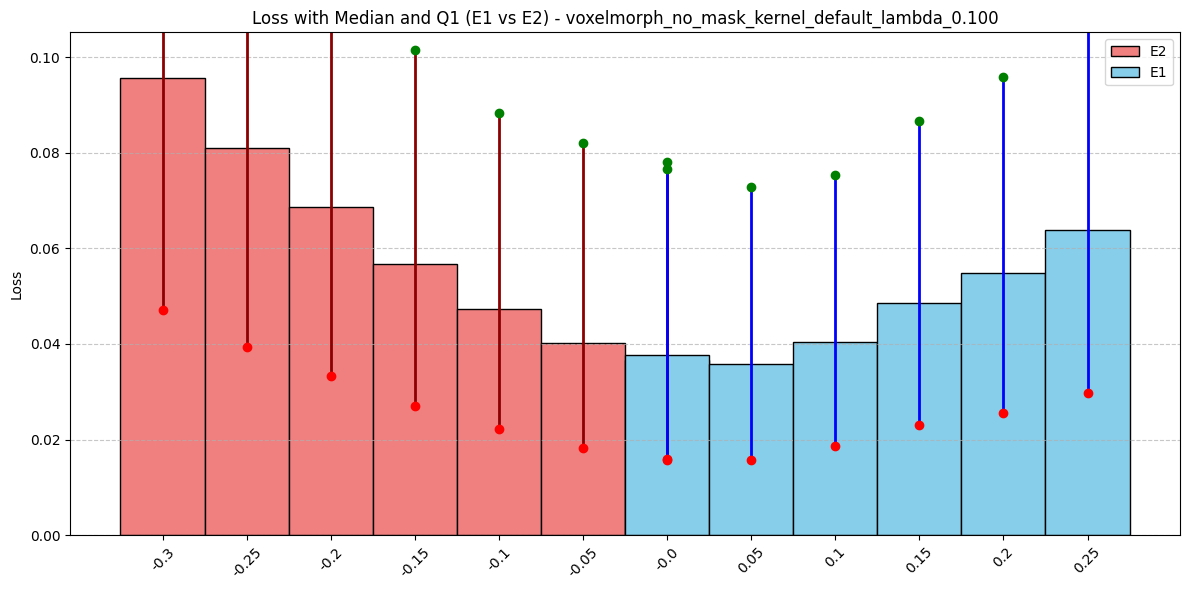

2025-06-27 18:46:15,094 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:46:15,095 - INFO -    Processed: 877 samples
2025-06-27 18:46:15,096 - INFO -    Batches: 110 processed, 0 skipped



Evaluating voxelmorph_no_mask (kernel=default, λ=0.2)
Progress: 1/2


2025-06-27 18:46:15,708 - INFO - Loading best model: best_model_val_loss_0.00386.weights.h5 (val_loss=0.003860)
c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:46:16,350 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:46:16,351 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:42<00:00,  2.61it/s, samples=877, skipped=0]


0.2048462252027905
Range -0.30: MSE = 0.204846, Active Pixels = 2376
0.1553974376273441
Range -0.25: MSE = 0.155397, Active Pixels = 7056
0.11422297045920832
Range -0.20: MSE = 0.114223, Active Pixels = 14466
0.08379700862302986
Range -0.15: MSE = 0.083797, Active Pixels = 20827
0.06021163529324869
Range -0.10: MSE = 0.060212, Active Pixels = 29817
0.04102097580225442
Range -0.05: MSE = 0.041021, Active Pixels = 64287
0.0347533607155973
Range -0.00: MSE = 0.034753, Active Pixels = 171576
0.035184609525633535
Range 0.05: MSE = 0.035185, Active Pixels = 327756
0.04236435164799077
Range 0.10: MSE = 0.042364, Active Pixels = 428131
0.052748075962887914
Range 0.15: MSE = 0.052748, Active Pixels = 464780
0.06277139240772836
Range 0.20: MSE = 0.062771, Active Pixels = 449477
0.07556286859324313
Range 0.25: MSE = 0.075563, Active Pixels = 384960
[0.03331512 0.1049049  0.03920824 0.10900854 0.06135468 0.19063091
 0.13358032 0.09344187 0.19871964 0.1495391  0.11970986 0.25686486
 0.25292841 0.20

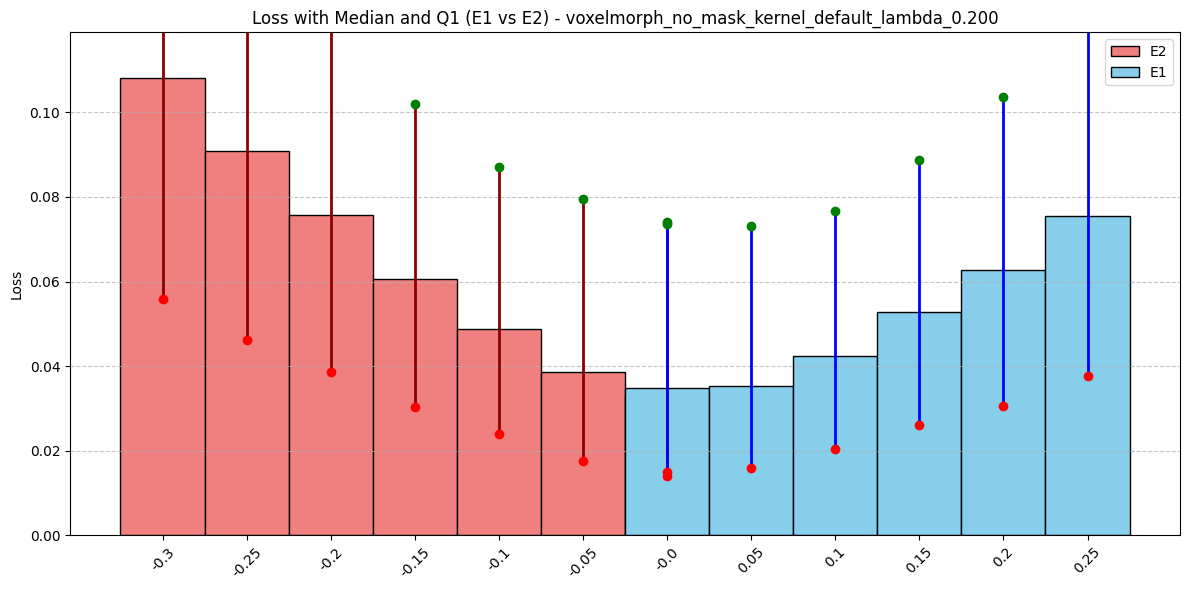

2025-06-27 18:47:08,697 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:47:08,698 - INFO -    Processed: 877 samples
2025-06-27 18:47:08,698 - INFO -    Batches: 110 processed, 0 skipped



Evaluating voxelmorph_no_mask (kernel=default, λ=0.3)
Progress: 2/3


2025-06-27 18:47:09,407 - INFO - Loading best model: best_model_val_loss_0.00430.weights.h5 (val_loss=0.004300)
c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:47:10,051 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:47:10,052 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:30<00:00,  3.56it/s, samples=877, skipped=0]


0.21441858709358927
Range -0.30: MSE = 0.214419, Active Pixels = 2376
0.15954676807973017
Range -0.25: MSE = 0.159547, Active Pixels = 7056
0.12008972637507015
Range -0.20: MSE = 0.120090, Active Pixels = 14466
0.08565808359567517
Range -0.15: MSE = 0.085658, Active Pixels = 20827
0.06107116917647698
Range -0.10: MSE = 0.061071, Active Pixels = 29817
0.039962179113571084
Range -0.05: MSE = 0.039962, Active Pixels = 64287
0.03398415846340634
Range -0.00: MSE = 0.033984, Active Pixels = 171576
0.035254431880074204
Range 0.05: MSE = 0.035254, Active Pixels = 327756
0.04447078209968702
Range 0.10: MSE = 0.044471, Active Pixels = 428131
0.057909364437066346
Range 0.15: MSE = 0.057909, Active Pixels = 464780
0.07019932441833654
Range 0.20: MSE = 0.070199, Active Pixels = 449477
0.08501331501193449
Range 0.25: MSE = 0.085013, Active Pixels = 384960
[0.0498921  0.11321138 0.06426207 0.1166645  0.08513323 0.18613982
 0.14023508 0.10803194 0.1887062  0.14740284 0.12760387 0.22829528
 0.22230059 

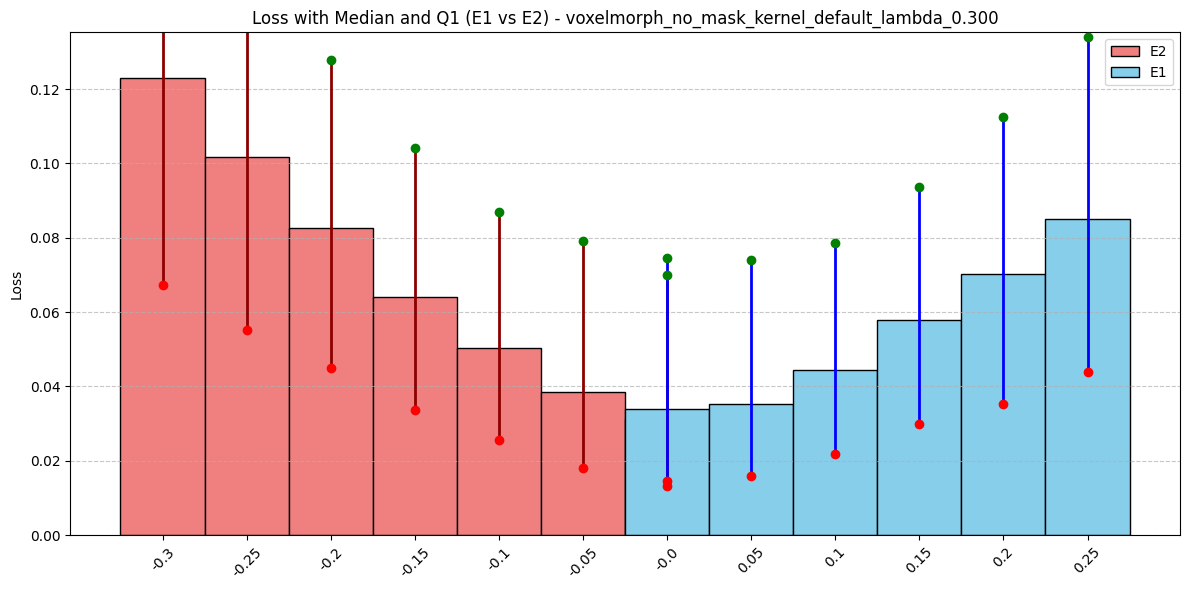

2025-06-27 18:47:50,941 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:47:50,942 - INFO -    Processed: 877 samples
2025-06-27 18:47:50,942 - INFO -    Batches: 110 processed, 0 skipped



Evaluating voxelmorph_no_mask (kernel=default, λ=0.4)
Progress: 3/4


2025-06-27 18:47:51,608 - INFO - Loading best model: best_model_val_loss_0.00461.weights.h5 (val_loss=0.004610)
c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:47:52,197 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:47:52,197 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:26<00:00,  4.14it/s, samples=877, skipped=0]


0.22423820952272355
Range -0.30: MSE = 0.224238, Active Pixels = 2376
0.1701956295307987
Range -0.25: MSE = 0.170196, Active Pixels = 7056
0.12487150937422511
Range -0.20: MSE = 0.124872, Active Pixels = 14466
0.08797384574865441
Range -0.15: MSE = 0.087974, Active Pixels = 20827
0.06010506066923468
Range -0.10: MSE = 0.060105, Active Pixels = 29817
0.03797493579134012
Range -0.05: MSE = 0.037975, Active Pixels = 64287
0.03257226624599491
Range -0.00: MSE = 0.032572, Active Pixels = 171576
0.034068076495746086
Range 0.05: MSE = 0.034068, Active Pixels = 327756
0.046065603505329594
Range 0.10: MSE = 0.046066, Active Pixels = 428131
0.06181664110123637
Range 0.15: MSE = 0.061817, Active Pixels = 464780
0.07651739183011863
Range 0.20: MSE = 0.076517, Active Pixels = 449477
0.0952236328141019
Range 0.25: MSE = 0.095224, Active Pixels = 384960
[0.10156572 0.15268334 0.07080621 0.11050244 0.07388616 0.16125086
 0.11726903 0.09139038 0.16507759 0.12996947 0.10909369 0.20864065
 0.21451928 0.1

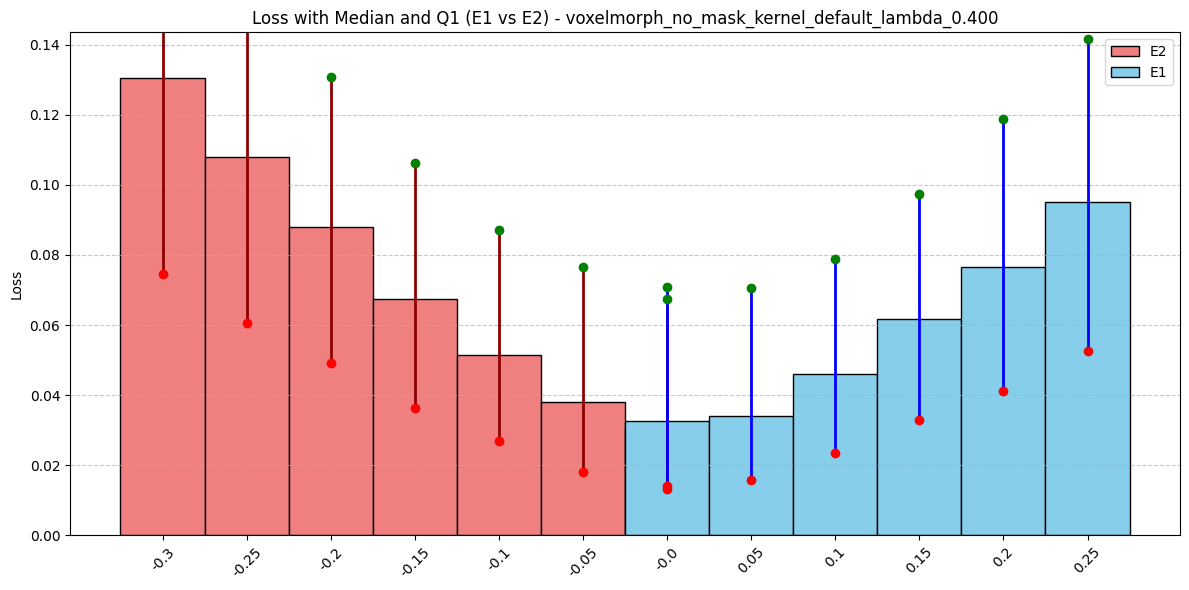

2025-06-27 18:48:29,226 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:48:29,227 - INFO -    Processed: 877 samples
2025-06-27 18:48:29,228 - INFO -    Batches: 110 processed, 0 skipped



Evaluating voxelmorph_no_mask (kernel=default, λ=0.5)
Progress: 4/5


2025-06-27 18:48:29,969 - INFO - Loading best model: best_model_val_loss_0.00505.weights.h5 (val_loss=0.005050)
c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:48:30,597 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:48:30,597 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:31<00:00,  3.54it/s, samples=877, skipped=0]


0.23159672894983874
Range -0.30: MSE = 0.231597, Active Pixels = 2376
0.18166894211040135
Range -0.25: MSE = 0.181669, Active Pixels = 7056
0.1358268070597221
Range -0.20: MSE = 0.135827, Active Pixels = 14466
0.09504462170912167
Range -0.15: MSE = 0.095045, Active Pixels = 20827
0.06574224023890156
Range -0.10: MSE = 0.065742, Active Pixels = 29817
0.041046087620726285
Range -0.05: MSE = 0.041046, Active Pixels = 64287
0.0328129391822318
Range -0.00: MSE = 0.032813, Active Pixels = 171576
0.03473495274990771
Range 0.05: MSE = 0.034735, Active Pixels = 327756
0.04791123616330306
Range 0.10: MSE = 0.047911, Active Pixels = 428131
0.0658333501587004
Range 0.15: MSE = 0.065833, Active Pixels = 464780
0.08412568989536068
Range 0.20: MSE = 0.084126, Active Pixels = 449477
0.10466975271294793
Range 0.25: MSE = 0.104670, Active Pixels = 384960
[0.08990103 0.11605216 0.07860801 0.1072172  0.0869579  0.15830141
 0.12133757 0.09987118 0.15759895 0.12593638 0.10696572 0.1886728
 0.18729361 0.1498

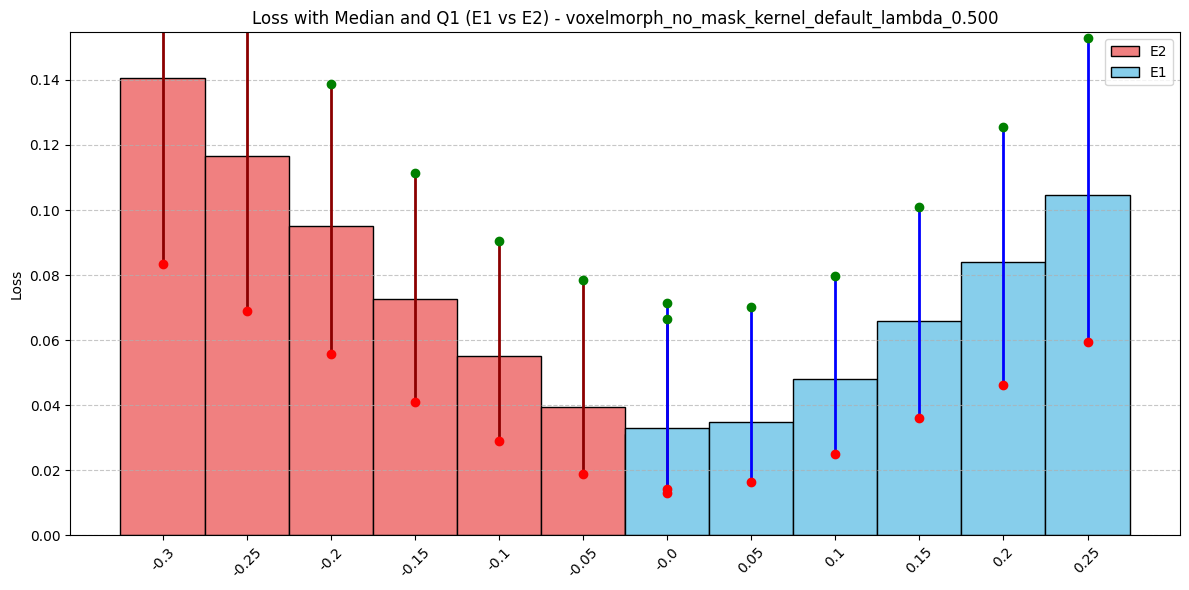

2025-06-27 18:49:13,123 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:49:13,124 - INFO -    Processed: 877 samples
2025-06-27 18:49:13,125 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:49:13,722 - INFO - Loading best model: best_model_val_loss_0.00604.weights.h5 (val_loss=0.006040)



Evaluating voxelmorph_no_mask (kernel=default, λ=0.6)
Progress: 5/6


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:49:14,379 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:49:14,380 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:32<00:00,  3.42it/s, samples=877, skipped=0]


0.2541862905704976
Range -0.30: MSE = 0.254186, Active Pixels = 2376
0.19781524873162323
Range -0.25: MSE = 0.197815, Active Pixels = 7056
0.14877667449525298
Range -0.20: MSE = 0.148777, Active Pixels = 14466
0.10517023092913652
Range -0.15: MSE = 0.105170, Active Pixels = 20827
0.07126932853518564
Range -0.10: MSE = 0.071269, Active Pixels = 29817
0.03990519843760532
Range -0.05: MSE = 0.039905, Active Pixels = 64287
0.031100770958681648
Range -0.00: MSE = 0.031101, Active Pixels = 171576
0.03582329347098967
Range 0.05: MSE = 0.035823, Active Pixels = 327756
0.05289912897723005
Range 0.10: MSE = 0.052899, Active Pixels = 428131
0.0745402474840297
Range 0.15: MSE = 0.074540, Active Pixels = 464780
0.09438336925593122
Range 0.20: MSE = 0.094383, Active Pixels = 449477
0.11700337108931935
Range 0.25: MSE = 0.117003, Active Pixels = 384960
[0.10207631 0.14933513 0.12081888 0.15704279 0.13403714 0.20332975
 0.16669423 0.14112105 0.19699493 0.16309141 0.14071189 0.21167404
 0.21699101 0.17

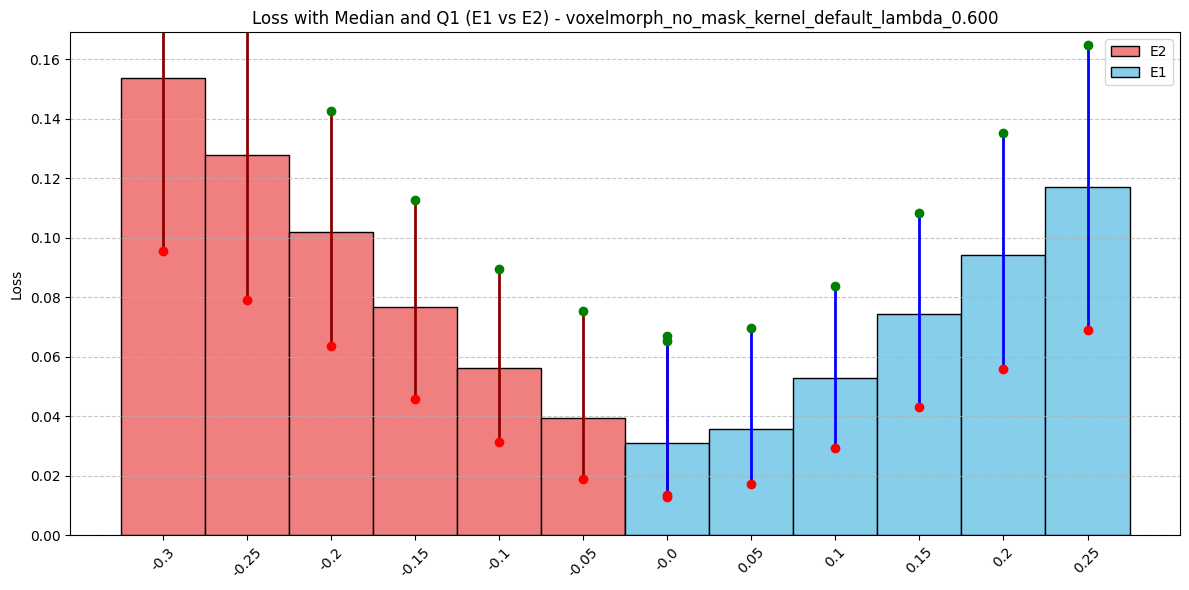

2025-06-27 18:49:58,082 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:49:58,083 - INFO -    Processed: 877 samples
2025-06-27 18:49:58,083 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:49:58,664 - INFO - Loading best model: best_model_val_loss_0.00622.weights.h5 (val_loss=0.006220)



Evaluating voxelmorph_no_mask (kernel=default, λ=0.7)
Progress: 6/7


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:49:59,270 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:49:59,271 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:34<00:00,  3.20it/s, samples=877, skipped=0]


0.25581933695398645
Range -0.30: MSE = 0.255819, Active Pixels = 2376
0.20145097081433852
Range -0.25: MSE = 0.201451, Active Pixels = 7056
0.15055325442565243
Range -0.20: MSE = 0.150553, Active Pixels = 14466
0.10654923290633811
Range -0.15: MSE = 0.106549, Active Pixels = 20827
0.07222247326751852
Range -0.10: MSE = 0.072222, Active Pixels = 29817
0.041619295813332416
Range -0.05: MSE = 0.041619, Active Pixels = 64287
0.031240510633216294
Range -0.00: MSE = 0.031241, Active Pixels = 171576
0.034918039191265945
Range 0.05: MSE = 0.034918, Active Pixels = 327756
0.05229568348153227
Range 0.10: MSE = 0.052296, Active Pixels = 428131
0.07442527350987284
Range 0.15: MSE = 0.074425, Active Pixels = 464780
0.09584812471105048
Range 0.20: MSE = 0.095848, Active Pixels = 449477
0.11982338650892463
Range 0.25: MSE = 0.119823, Active Pixels = 384960
[0.13412494 0.1569734  0.12487913 0.14835142 0.12278448 0.18485021
 0.14878685 0.12247946 0.17344063 0.14003587 0.12360127 0.19406288
 0.19282897 

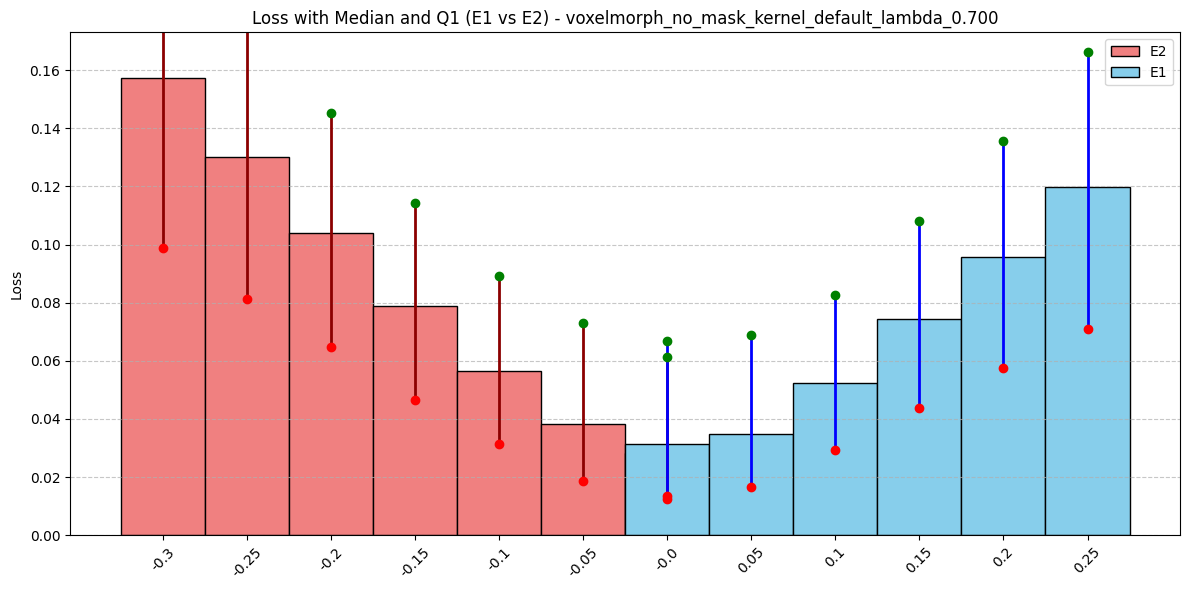

2025-06-27 18:50:45,349 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:50:45,350 - INFO -    Processed: 877 samples
2025-06-27 18:50:45,351 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:50:45,952 - INFO - Loading best model: best_model_val_loss_0.00649.weights.h5 (val_loss=0.006490)



Evaluating voxelmorph_no_mask (kernel=default, λ=0.8)
Progress: 7/8


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:50:46,615 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:50:46,616 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:35<00:00,  3.12it/s, samples=877, skipped=0]


0.26212382634284265
Range -0.30: MSE = 0.262124, Active Pixels = 2376
0.2105914103774671
Range -0.25: MSE = 0.210591, Active Pixels = 7056
0.15826747814311426
Range -0.20: MSE = 0.158267, Active Pixels = 14466
0.11241187597935676
Range -0.15: MSE = 0.112412, Active Pixels = 20827
0.07359264196279783
Range -0.10: MSE = 0.073593, Active Pixels = 29817
0.040595626638522064
Range -0.05: MSE = 0.040596, Active Pixels = 64287
0.030063386480935143
Range -0.00: MSE = 0.030063, Active Pixels = 171576
0.036025002307255506
Range 0.05: MSE = 0.036025, Active Pixels = 327756
0.05480210449156128
Range 0.10: MSE = 0.054802, Active Pixels = 428131
0.0783375724854064
Range 0.15: MSE = 0.078338, Active Pixels = 464780
0.1014617374183763
Range 0.20: MSE = 0.101462, Active Pixels = 449477
0.12537124272590539
Range 0.25: MSE = 0.125371, Active Pixels = 384960
[0.15469225 0.18514818 0.14350752 0.16923444 0.14000763 0.19995905
 0.16702577 0.14054539 0.19426742 0.16481212 0.14571467 0.20713143
 0.2205945  0.1

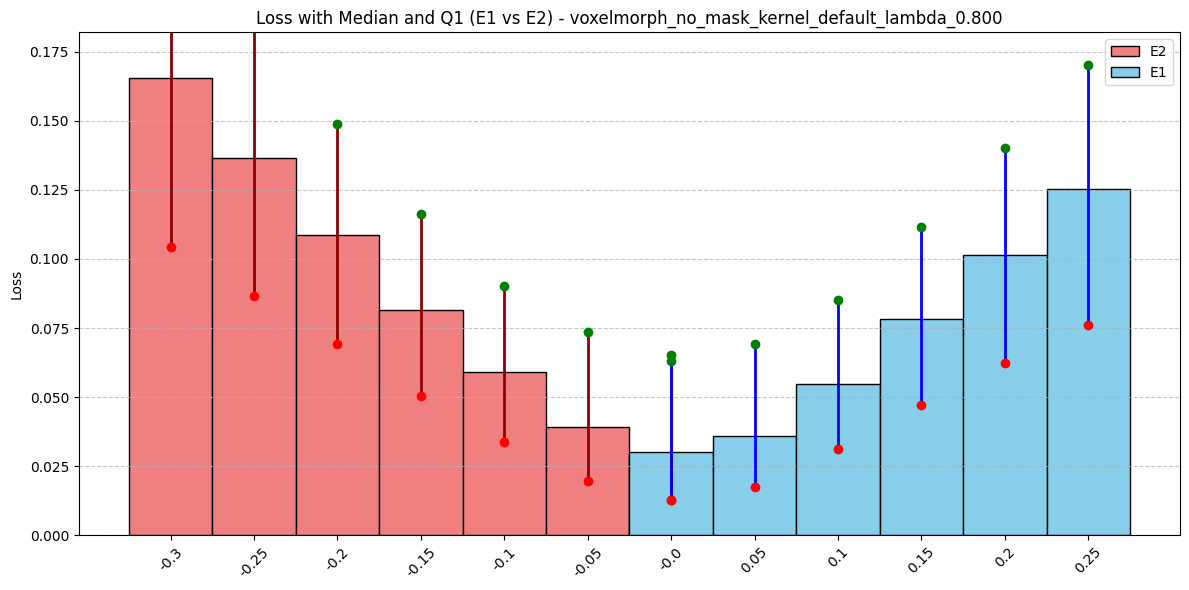

2025-06-27 18:51:34,747 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:51:34,748 - INFO -    Processed: 877 samples
2025-06-27 18:51:34,748 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:51:35,186 - INFO - Loading best model: best_model_val_loss_0.00661.weights.h5 (val_loss=0.006610)



Evaluating voxelmorph_no_mask (kernel=default, λ=0.9)
Progress: 8/9


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:51:35,819 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:51:35,820 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:31<00:00,  3.52it/s, samples=877, skipped=0]


0.26612291747330646
Range -0.30: MSE = 0.266123, Active Pixels = 2376
0.21500139104169572
Range -0.25: MSE = 0.215001, Active Pixels = 7056
0.1608404629333321
Range -0.20: MSE = 0.160840, Active Pixels = 14466
0.11562159082874207
Range -0.15: MSE = 0.115622, Active Pixels = 20827
0.077517741845315
Range -0.10: MSE = 0.077518, Active Pixels = 29817
0.04229105184346308
Range -0.05: MSE = 0.042291, Active Pixels = 64287
0.029366533276681924
Range -0.00: MSE = 0.029367, Active Pixels = 171576
0.03579117268791072
Range 0.05: MSE = 0.035791, Active Pixels = 327756
0.05587316172444878
Range 0.10: MSE = 0.055873, Active Pixels = 428131
0.08051684511564967
Range 0.15: MSE = 0.080517, Active Pixels = 464780
0.10505539724212373
Range 0.20: MSE = 0.105055, Active Pixels = 449477
0.1320560944027865
Range 0.25: MSE = 0.132056, Active Pixels = 384960
[0.15841572 0.18185824 0.15726888 0.17644238 0.15917927 0.2006759
 0.1776225  0.16150376 0.19311032 0.17327157 0.16040223 0.1891359
 0.20381657 0.179967

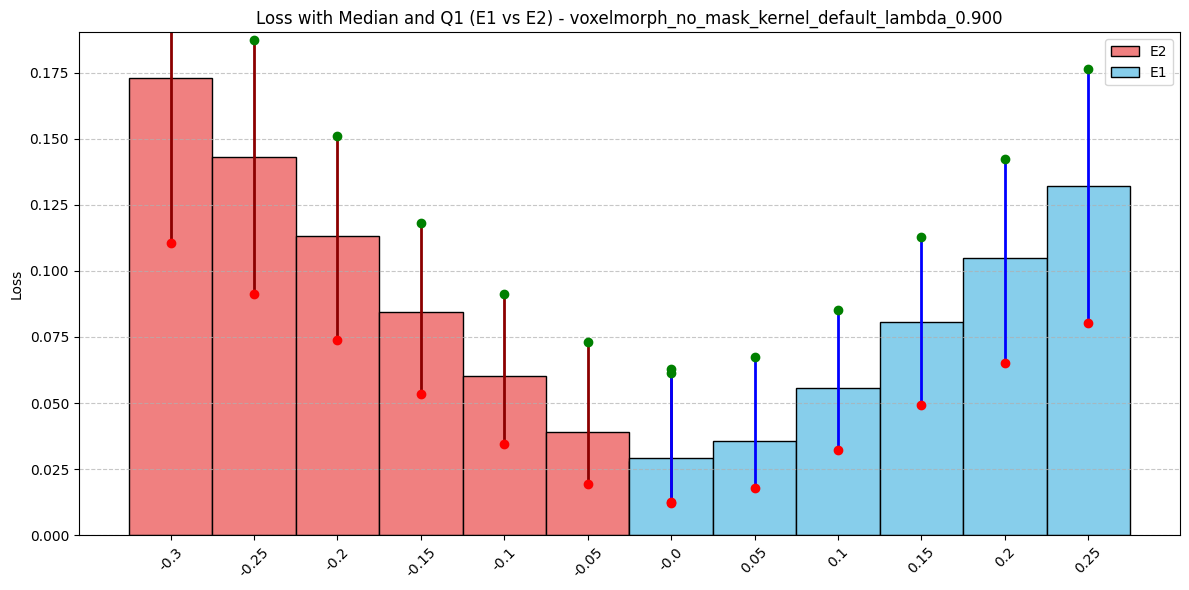

2025-06-27 18:52:20,146 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:52:20,147 - INFO -    Processed: 877 samples
2025-06-27 18:52:20,147 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:52:20,706 - INFO - Loading best model: best_model_val_loss_0.00679.weights.h5 (val_loss=0.006790)



Evaluating voxelmorph_no_mask (kernel=default, λ=1.0)
Progress: 9/10


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:52:21,333 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:52:21,334 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:38<00:00,  2.86it/s, samples=877, skipped=0]


0.2641437437985434
Range -0.30: MSE = 0.264144, Active Pixels = 2376
0.21422632631135657
Range -0.25: MSE = 0.214226, Active Pixels = 7056
0.16297613342941591
Range -0.20: MSE = 0.162976, Active Pixels = 14466
0.11711847483725285
Range -0.15: MSE = 0.117118, Active Pixels = 20827
0.07805452238344246
Range -0.10: MSE = 0.078055, Active Pixels = 29817
0.04006015641713925
Range -0.05: MSE = 0.040060, Active Pixels = 64287
0.028530839805738936
Range -0.00: MSE = 0.028531, Active Pixels = 171576
0.03647030963113955
Range 0.05: MSE = 0.036470, Active Pixels = 327756
0.057356464799585644
Range 0.10: MSE = 0.057356, Active Pixels = 428131
0.0828342106660049
Range 0.15: MSE = 0.082834, Active Pixels = 464780
0.1077432878285961
Range 0.20: MSE = 0.107743, Active Pixels = 449477
0.13480229165684543
Range 0.25: MSE = 0.134802, Active Pixels = 384960
[0.1721155  0.19729973 0.17257742 0.19593975 0.17372953 0.22138563
 0.19616621 0.17352902 0.21578094 0.19142613 0.17122249 0.21358377
 0.23183061 0.20

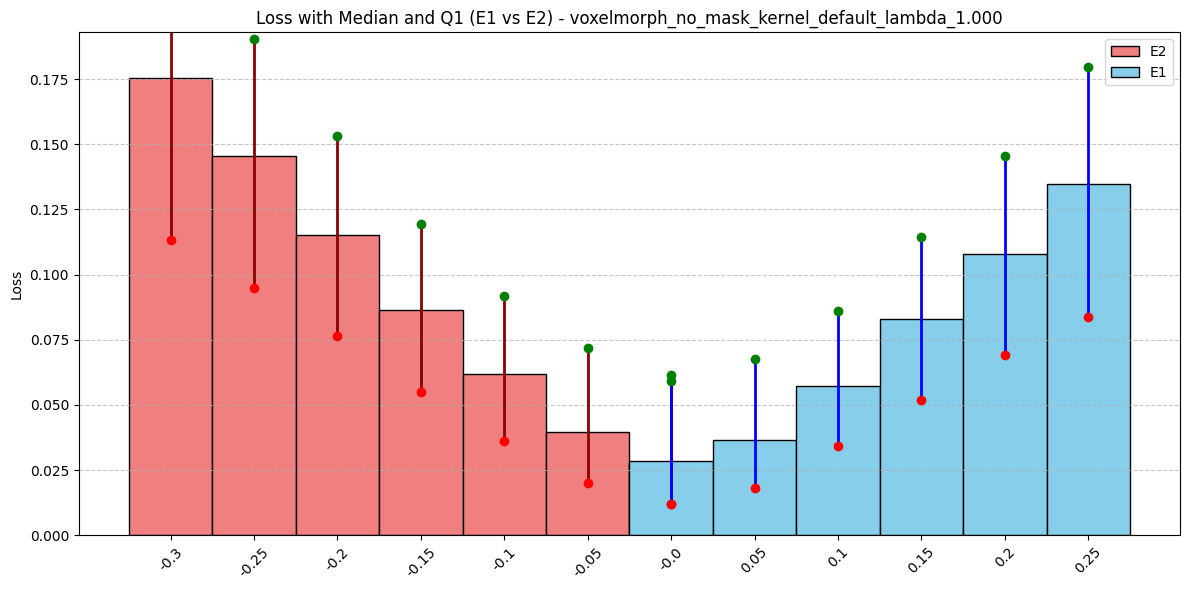

2025-06-27 18:53:13,883 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:53:13,884 - INFO -    Processed: 877 samples
2025-06-27 18:53:13,885 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:53:14,467 - INFO - Loading best model: best_model_val_loss_0.00365.weights.h5 (val_loss=0.003650)



Evaluating voxelmorph_no_mask (kernel=first5, λ=0.1)
Progress: 10/11


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:53:15,139 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:53:15,140 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:31<00:00,  3.46it/s, samples=877, skipped=0]


0.1948026077323554
Range -0.30: MSE = 0.194803, Active Pixels = 2376
0.1496368647359897
Range -0.25: MSE = 0.149637, Active Pixels = 7056
0.1155482490922558
Range -0.20: MSE = 0.115548, Active Pixels = 14466
0.08827854820657849
Range -0.15: MSE = 0.088279, Active Pixels = 20827
0.0657011583780337
Range -0.10: MSE = 0.065701, Active Pixels = 29817
0.045644043370642914
Range -0.05: MSE = 0.045644, Active Pixels = 64287
0.03921889753596979
Range -0.00: MSE = 0.039219, Active Pixels = 171576
0.03778179372894919
Range 0.05: MSE = 0.037782, Active Pixels = 327756
0.042057785284698834
Range 0.10: MSE = 0.042058, Active Pixels = 428131
0.05084961356504521
Range 0.15: MSE = 0.050850, Active Pixels = 464780
0.05744100848636857
Range 0.20: MSE = 0.057441, Active Pixels = 449477
0.06562240571312095
Range 0.25: MSE = 0.065622, Active Pixels = 384960
[2.99131565e-02 3.58509245e-02 1.64482211e-02 4.77568557e-02
 5.63648430e-03 1.40887318e-01 7.53104871e-02 3.37697647e-02
 1.43324921e-01 8.31157323e-0

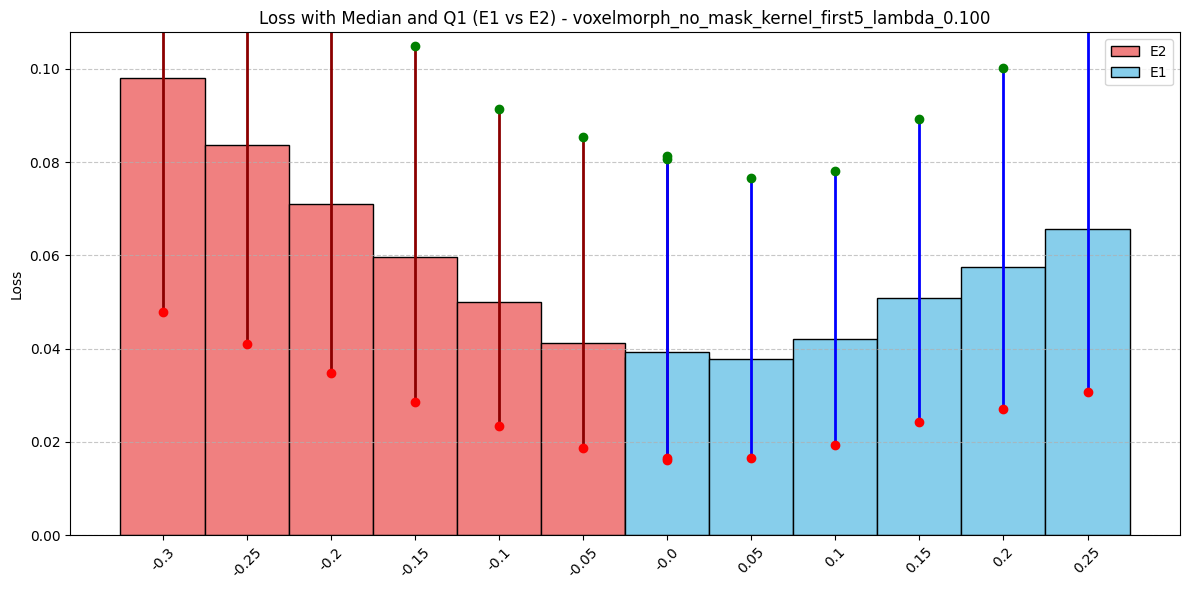

2025-06-27 18:54:01,962 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:54:01,964 - INFO -    Processed: 877 samples
2025-06-27 18:54:01,965 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:54:02,417 - ERROR - No valid model files found in ./data\Models\voxelmorph_no_mask_kernel_first5_lambda_0.200\weights
2025-06-27 18:54:02,419 - ERROR - Failed to load model for voxelmorph_no_mask (kernel=first5, λ=0.2)



Evaluating voxelmorph_no_mask (kernel=first5, λ=0.2)
Progress: 11/12


2025-06-27 18:54:02,885 - INFO - Loading best model: best_model_val_loss_0.00507.weights.h5 (val_loss=0.005070)



Evaluating voxelmorph_no_mask (kernel=first5, λ=0.3)
Progress: 12/13


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:54:03,650 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:54:03,651 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:29<00:00,  3.71it/s, samples=877, skipped=0]


0.22467597980252813
Range -0.30: MSE = 0.224676, Active Pixels = 2376
0.17067307795351827
Range -0.25: MSE = 0.170673, Active Pixels = 7056
0.12572175093825722
Range -0.20: MSE = 0.125722, Active Pixels = 14466
0.0887575541822117
Range -0.15: MSE = 0.088758, Active Pixels = 20827
0.06234716329105128
Range -0.10: MSE = 0.062347, Active Pixels = 29817
0.04158840796385329
Range -0.05: MSE = 0.041588, Active Pixels = 64287
0.03547309221200269
Range -0.00: MSE = 0.035473, Active Pixels = 171576
0.03699102280943305
Range 0.05: MSE = 0.036991, Active Pixels = 327756
0.04708242111891445
Range 0.10: MSE = 0.047082, Active Pixels = 428131
0.06201154430167963
Range 0.15: MSE = 0.062012, Active Pixels = 464780
0.07666155764811988
Range 0.20: MSE = 0.076662, Active Pixels = 449477
0.09352785745314902
Range 0.25: MSE = 0.093528, Active Pixels = 384960
[0.09871273 0.15224957 0.1097363  0.15892113 0.11725509 0.21488583
 0.16929309 0.12506574 0.21566291 0.16777732 0.13346971 0.24248992
 0.25064315 0.20

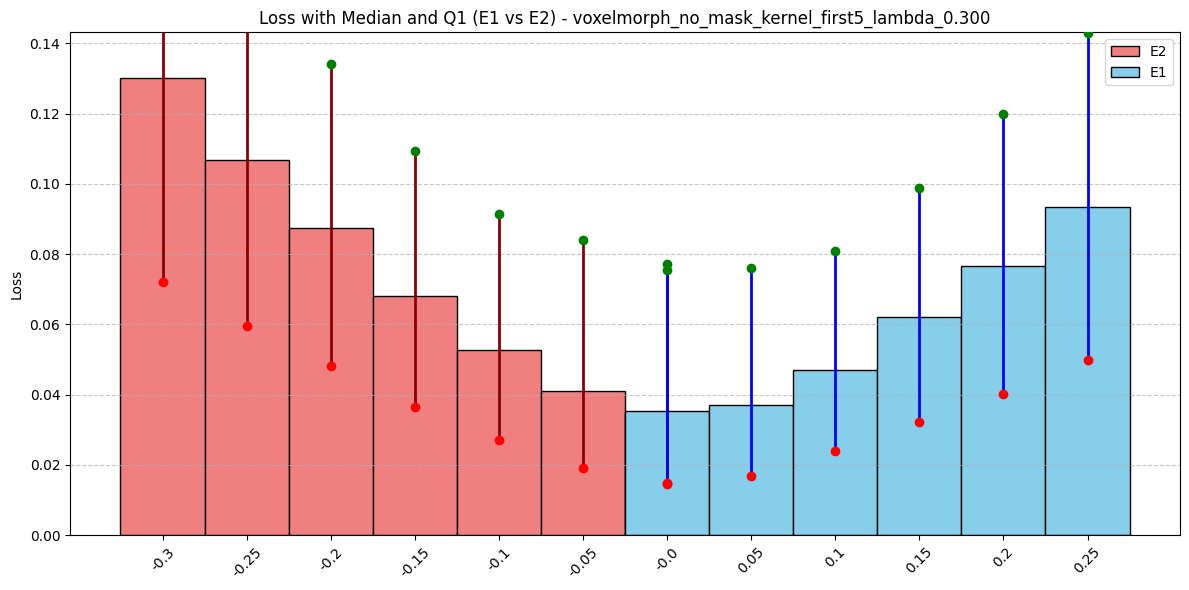

2025-06-27 18:54:47,663 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:54:47,664 - INFO -    Processed: 877 samples
2025-06-27 18:54:47,665 - INFO -    Batches: 110 processed, 0 skipped



Evaluating voxelmorph_no_mask (kernel=first5, λ=0.4)
Progress: 13/14


2025-06-27 18:54:48,368 - INFO - Loading best model: best_model_val_loss_0.00537.weights.h5 (val_loss=0.005370)
c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:54:49,024 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:54:49,024 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:30<00:00,  3.64it/s, samples=877, skipped=0]


0.23579607408029812
Range -0.30: MSE = 0.235796, Active Pixels = 2376
0.17830972594514788
Range -0.25: MSE = 0.178310, Active Pixels = 7056
0.13267260158715524
Range -0.20: MSE = 0.132673, Active Pixels = 14466
0.0935373501089024
Range -0.15: MSE = 0.093537, Active Pixels = 20827
0.061646571027597685
Range -0.10: MSE = 0.061647, Active Pixels = 29817
0.03968472578554585
Range -0.05: MSE = 0.039685, Active Pixels = 64287
0.032998407331789874
Range -0.00: MSE = 0.032998, Active Pixels = 171576
0.03480470981780874
Range 0.05: MSE = 0.034805, Active Pixels = 327756
0.0474445844628574
Range 0.10: MSE = 0.047445, Active Pixels = 428131
0.06391200047464415
Range 0.15: MSE = 0.063912, Active Pixels = 464780
0.07971769116913568
Range 0.20: MSE = 0.079718, Active Pixels = 449477
0.09756031565209591
Range 0.25: MSE = 0.097560, Active Pixels = 384960
[0.09974885 0.16204308 0.10225915 0.15561985 0.11600047 0.2145194
 0.17033257 0.13323533 0.21581058 0.17553488 0.13576427 0.23671738
 0.24381864 0.20

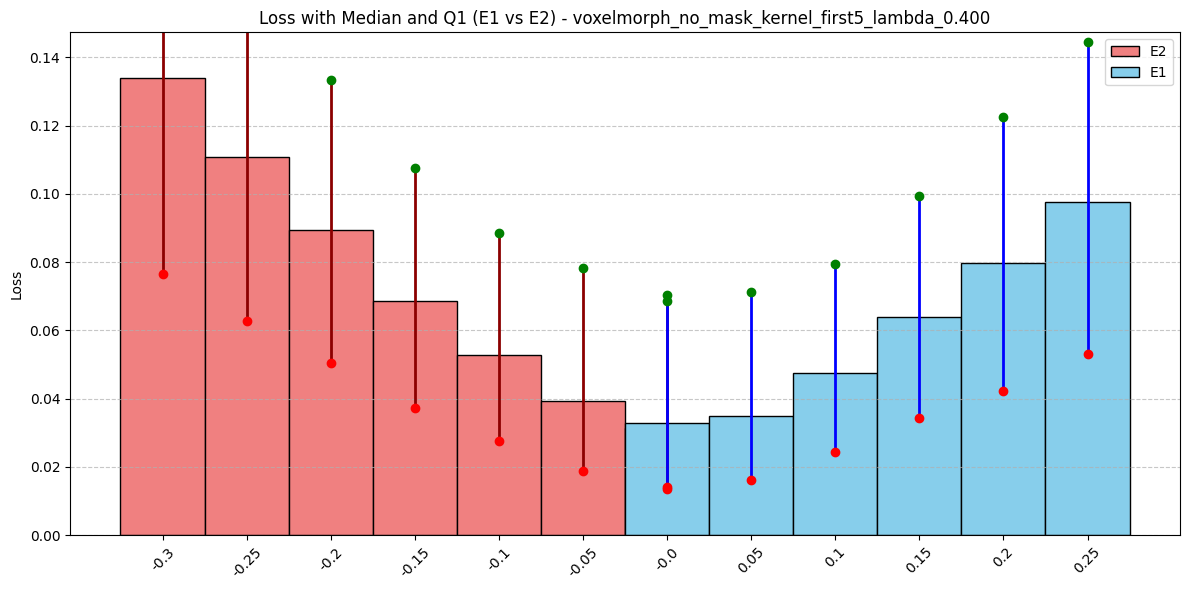

2025-06-27 18:55:33,858 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:55:33,858 - INFO -    Processed: 877 samples
2025-06-27 18:55:33,859 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:55:34,426 - INFO - Loading best model: best_model_val_loss_0.00569.weights.h5 (val_loss=0.005690)



Evaluating voxelmorph_no_mask (kernel=first5, λ=0.5)
Progress: 14/15


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:55:35,089 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:55:35,090 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:30<00:00,  3.65it/s, samples=877, skipped=0]


0.23974036427117806
Range -0.30: MSE = 0.239740, Active Pixels = 2376
0.18749084921257406
Range -0.25: MSE = 0.187491, Active Pixels = 7056
0.1399949892436527
Range -0.20: MSE = 0.139995, Active Pixels = 14466
0.09834219542833184
Range -0.15: MSE = 0.098342, Active Pixels = 20827
0.06806843949690633
Range -0.10: MSE = 0.068068, Active Pixels = 29817
0.03997079099585647
Range -0.05: MSE = 0.039971, Active Pixels = 64287
0.031097726738971855
Range -0.00: MSE = 0.031098, Active Pixels = 171576
0.03513477511224675
Range 0.05: MSE = 0.035135, Active Pixels = 327756
0.049536854512918865
Range 0.10: MSE = 0.049537, Active Pixels = 428131
0.06866624437332866
Range 0.15: MSE = 0.068666, Active Pixels = 464780
0.08621700655153497
Range 0.20: MSE = 0.086217, Active Pixels = 449477
0.10730737258892101
Range 0.25: MSE = 0.107307, Active Pixels = 384960
[0.12899447 0.16223936 0.1337371  0.16413527 0.14110282 0.20494643
 0.17143698 0.14419229 0.19869206 0.16554131 0.14960188 0.20960454
 0.21604459 0.

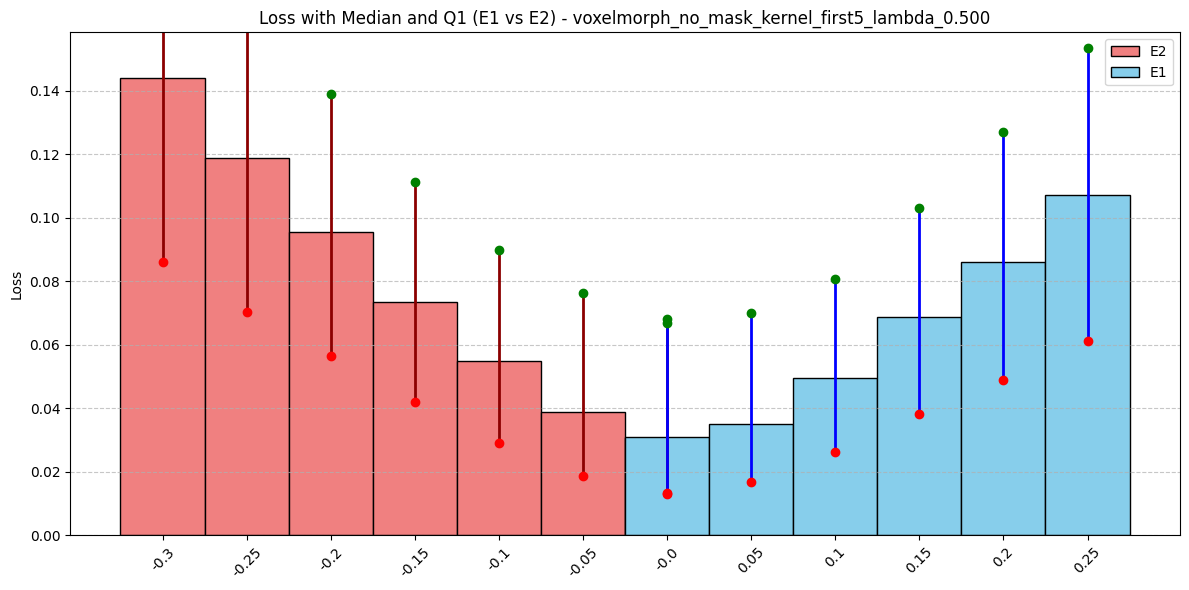

2025-06-27 18:56:20,494 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:56:20,495 - INFO -    Processed: 877 samples
2025-06-27 18:56:20,495 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:56:20,885 - ERROR - No valid model files found in ./data\Models\voxelmorph_no_mask_kernel_first5_lambda_0.600\weights
2025-06-27 18:56:20,886 - ERROR - Failed to load model for voxelmorph_no_mask (kernel=first5, λ=0.6)



Evaluating voxelmorph_no_mask (kernel=first5, λ=0.6)
Progress: 15/16

Evaluating voxelmorph_no_mask (kernel=first5, λ=0.7)
Progress: 16/17


2025-06-27 18:56:21,501 - INFO - Loading best model: best_model_val_loss_0.00617.weights.h5 (val_loss=0.006170)
c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:56:22,107 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:56:22,108 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:31<00:00,  3.46it/s, samples=877, skipped=0]


0.25230207083999234
Range -0.30: MSE = 0.252302, Active Pixels = 2376
0.1986990936559444
Range -0.25: MSE = 0.198699, Active Pixels = 7056
0.14890492589971804
Range -0.20: MSE = 0.148905, Active Pixels = 14466
0.10589128740009812
Range -0.15: MSE = 0.105891, Active Pixels = 20827
0.06956235412582487
Range -0.10: MSE = 0.069562, Active Pixels = 29817
0.039800335545567014
Range -0.05: MSE = 0.039800, Active Pixels = 64287
0.03044511707742256
Range -0.00: MSE = 0.030445, Active Pixels = 171576
0.03534147803673857
Range 0.05: MSE = 0.035341, Active Pixels = 327756
0.05244697788412728
Range 0.10: MSE = 0.052447, Active Pixels = 428131
0.07517235321048867
Range 0.15: MSE = 0.075172, Active Pixels = 464780
0.09668973211985718
Range 0.20: MSE = 0.096690, Active Pixels = 449477
0.119616195129464
Range 0.25: MSE = 0.119616, Active Pixels = 384960
[0.1289746  0.16245837 0.13489366 0.16535335 0.14194256 0.20721152
 0.17437627 0.14922612 0.20582579 0.17471493 0.14663978 0.21738787
 0.23057834 0.197

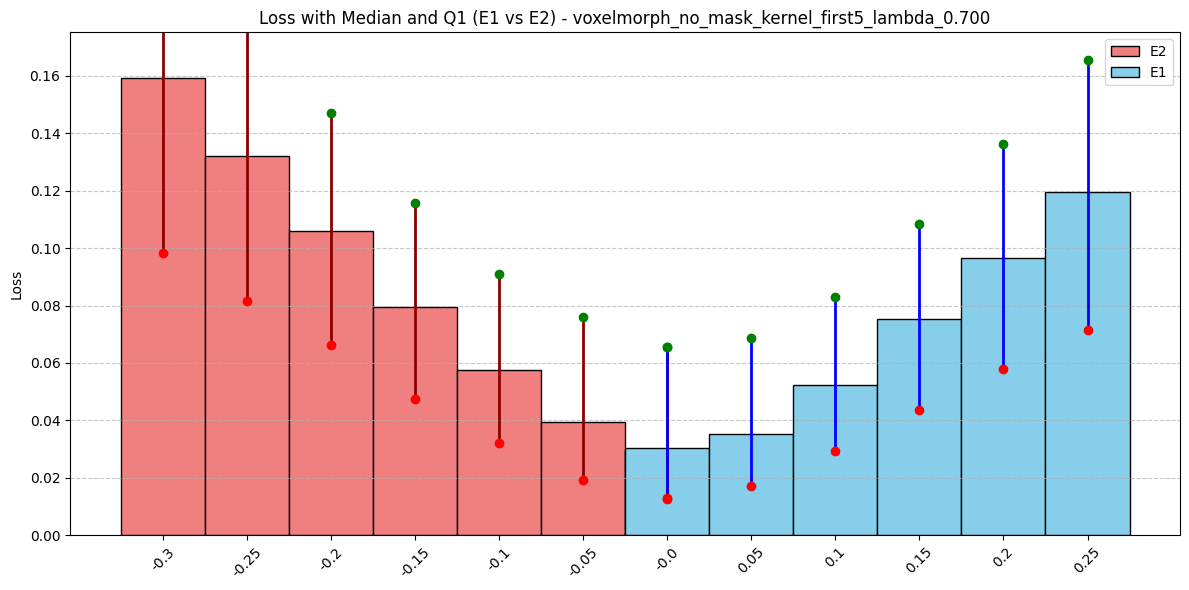

2025-06-27 18:57:08,865 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:57:08,867 - INFO -    Processed: 877 samples
2025-06-27 18:57:08,867 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:57:09,408 - INFO - Loading best model: best_model_val_loss_0.00653.weights.h5 (val_loss=0.006530)



Evaluating voxelmorph_no_mask (kernel=first5, λ=0.8)
Progress: 17/18


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:57:10,030 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:57:10,031 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:33<00:00,  3.24it/s, samples=877, skipped=0]


0.2529360964164007
Range -0.30: MSE = 0.252936, Active Pixels = 2376
0.2037551535371306
Range -0.25: MSE = 0.203755, Active Pixels = 7056
0.15337493606073066
Range -0.20: MSE = 0.153375, Active Pixels = 14466
0.10972394077515346
Range -0.15: MSE = 0.109724, Active Pixels = 20827
0.07399776329714422
Range -0.10: MSE = 0.073998, Active Pixels = 29817
0.042365108931301486
Range -0.05: MSE = 0.042365, Active Pixels = 64287
0.030404808785002874
Range -0.00: MSE = 0.030405, Active Pixels = 171576
0.03637926335501015
Range 0.05: MSE = 0.036379, Active Pixels = 327756
0.055101635854871656
Range 0.10: MSE = 0.055102, Active Pixels = 428131
0.07958356891912337
Range 0.15: MSE = 0.079584, Active Pixels = 464780
0.10329923908209296
Range 0.20: MSE = 0.103299, Active Pixels = 449477
0.1280571149672014
Range 0.25: MSE = 0.128057, Active Pixels = 384960
[0.14901097 0.17468449 0.14564083 0.16541857 0.14420405 0.188083
 0.16108567 0.14228306 0.17882394 0.15466814 0.14403188 0.18540938
 0.19689721 0.167

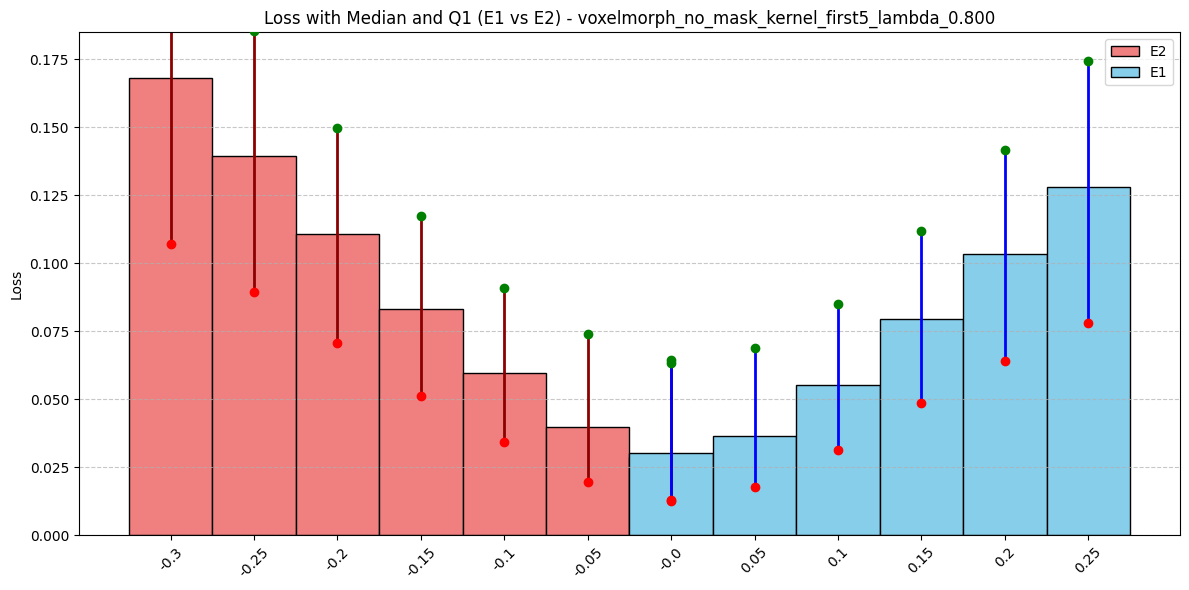

2025-06-27 18:58:00,398 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:58:00,398 - INFO -    Processed: 877 samples
2025-06-27 18:58:00,399 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:58:00,814 - INFO - Loading best model: best_model_val_loss_0.00671.weights.h5 (val_loss=0.006710)



Evaluating voxelmorph_no_mask (kernel=first5, λ=0.9)
Progress: 18/19


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:58:01,520 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:58:01,520 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:31<00:00,  3.51it/s, samples=877, skipped=0]


0.2608874052354377
Range -0.30: MSE = 0.260887, Active Pixels = 2376
0.2107940114959889
Range -0.25: MSE = 0.210794, Active Pixels = 7056
0.16118926768905423
Range -0.20: MSE = 0.161189, Active Pixels = 14466
0.11452347098159255
Range -0.15: MSE = 0.114523, Active Pixels = 20827
0.07592835351816614
Range -0.10: MSE = 0.075928, Active Pixels = 29817
0.04022610255243964
Range -0.05: MSE = 0.040226, Active Pixels = 64287
0.029313101691229426
Range -0.00: MSE = 0.029313, Active Pixels = 171576
0.03628129119900192
Range 0.05: MSE = 0.036281, Active Pixels = 327756
0.05584871697936902
Range 0.10: MSE = 0.055849, Active Pixels = 428131
0.07996782311133993
Range 0.15: MSE = 0.079968, Active Pixels = 464780
0.1035701400424302
Range 0.20: MSE = 0.103570, Active Pixels = 449477
0.1295920749550235
Range 0.25: MSE = 0.129592, Active Pixels = 384960
[0.13441353 0.1784117  0.12594626 0.16301801 0.12672283 0.20548612
 0.15999422 0.12978473 0.19379413 0.15474095 0.13949068 0.22936845
 0.22446132 0.1785

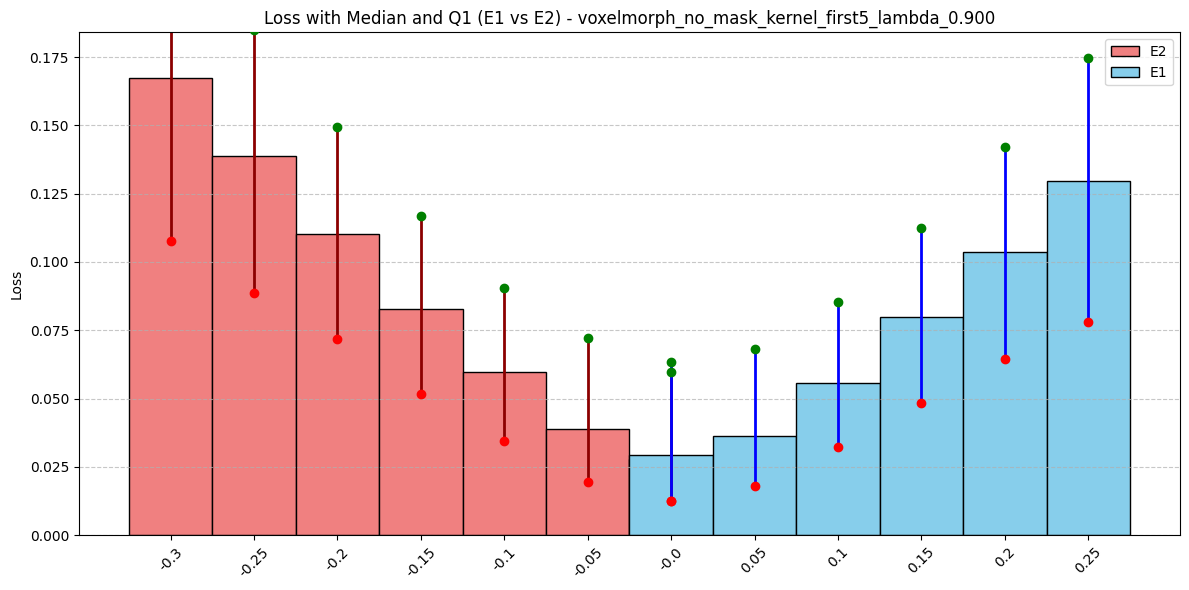

2025-06-27 18:58:50,643 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:58:50,643 - INFO -    Processed: 877 samples
2025-06-27 18:58:50,644 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:58:51,048 - ERROR - No valid model files found in ./data\Models\voxelmorph_no_mask_kernel_first5_lambda_1.000\weights
2025-06-27 18:58:51,049 - ERROR - Failed to load model for voxelmorph_no_mask (kernel=first5, λ=1.0)



Evaluating voxelmorph_no_mask (kernel=first5, λ=1.0)
Progress: 19/20


2025-06-27 18:58:51,356 - INFO - Loading best model: best_model_val_loss_0.00377.weights.h5 (val_loss=0.003770)



Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=0.1)
Progress: 20/21


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:58:52,031 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:58:52,032 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:32<00:00,  3.39it/s, samples=877, skipped=0]


0.19580299204063947
Range -0.30: MSE = 0.195803, Active Pixels = 2376
0.14768992141401702
Range -0.25: MSE = 0.147690, Active Pixels = 7056
0.11215067913627332
Range -0.20: MSE = 0.112151, Active Pixels = 14466
0.08716444868913795
Range -0.15: MSE = 0.087164, Active Pixels = 20827
0.064297986646685
Range -0.10: MSE = 0.064298, Active Pixels = 29817
0.04703469621958978
Range -0.05: MSE = 0.047035, Active Pixels = 64287
0.04022467420159927
Range -0.00: MSE = 0.040225, Active Pixels = 171576
0.0381828935056066
Range 0.05: MSE = 0.038183, Active Pixels = 327756
0.043262215487976055
Range 0.10: MSE = 0.043262, Active Pixels = 428131
0.05229606384871402
Range 0.15: MSE = 0.052296, Active Pixels = 464780
0.05983648829758695
Range 0.20: MSE = 0.059836, Active Pixels = 449477
0.06999409607194643
Range 0.25: MSE = 0.069994, Active Pixels = 384960
[5.34304075e-02 2.54988196e-02 3.12848900e-02 4.99144396e-02
 6.09368951e-04 1.51447324e-01 9.38297694e-02 4.91426967e-02
 1.69127831e-01 1.12249887e-0

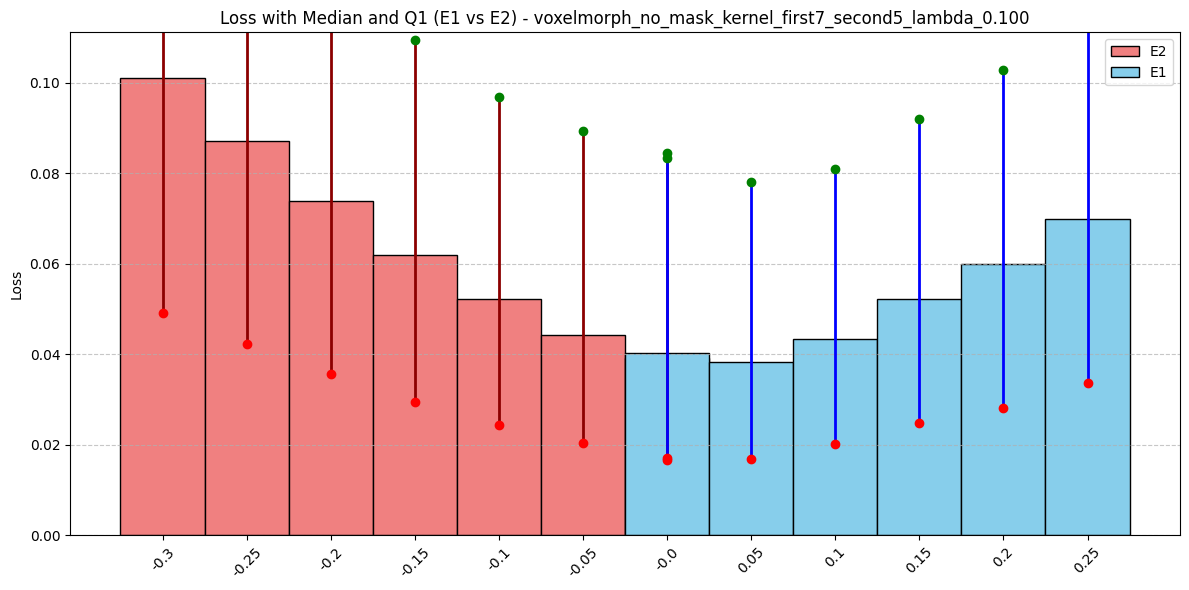

2025-06-27 18:59:42,716 - INFO - ✅ Evaluation completed successfully
2025-06-27 18:59:42,716 - INFO -    Processed: 877 samples
2025-06-27 18:59:42,717 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 18:59:43,122 - INFO - Loading best model: best_model_val_loss_0.00451.weights.h5 (val_loss=0.004510)



Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=0.2)
Progress: 21/22


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 18:59:43,818 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 18:59:43,819 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:35<00:00,  3.09it/s, samples=877, skipped=0]


0.22510233710979952
Range -0.30: MSE = 0.225102, Active Pixels = 2376
0.1664722877286832
Range -0.25: MSE = 0.166472, Active Pixels = 7056
0.12425278958204983
Range -0.20: MSE = 0.124253, Active Pixels = 14466
0.09188471950100818
Range -0.15: MSE = 0.091885, Active Pixels = 20827
0.06537764693585052
Range -0.10: MSE = 0.065378, Active Pixels = 29817
0.04196805820537568
Range -0.05: MSE = 0.041968, Active Pixels = 64287
0.036541991616812985
Range -0.00: MSE = 0.036542, Active Pixels = 171576
0.03766863562510736
Range 0.05: MSE = 0.037669, Active Pixels = 327756
0.04578735997591557
Range 0.10: MSE = 0.045787, Active Pixels = 428131
0.057227265473903124
Range 0.15: MSE = 0.057227, Active Pixels = 464780
0.06857411069349462
Range 0.20: MSE = 0.068574, Active Pixels = 449477
0.08166780543738766
Range 0.25: MSE = 0.081668, Active Pixels = 384960
[0.01837325 0.11408713 0.06492678 0.14098582 0.1008718  0.22206539
 0.1743363  0.13351102 0.23692922 0.19190247 0.15021379 0.27760296
 0.28548311 0.

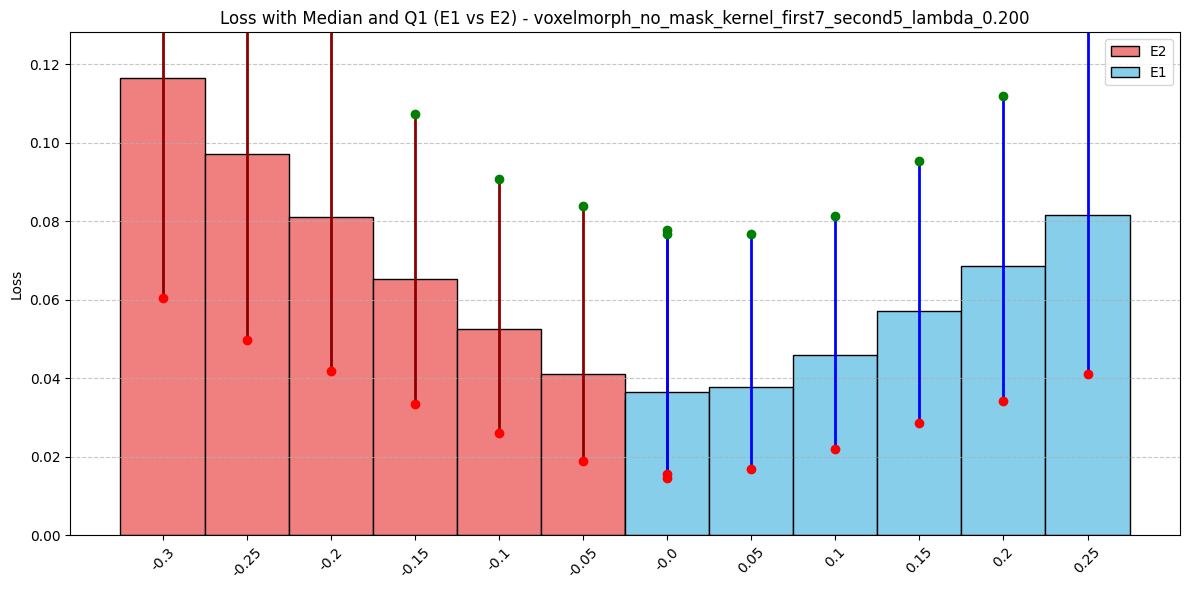

2025-06-27 19:00:36,973 - INFO - ✅ Evaluation completed successfully
2025-06-27 19:00:36,974 - INFO -    Processed: 877 samples
2025-06-27 19:00:36,975 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 19:00:37,430 - INFO - Loading best model: best_model_val_loss_0.00500.weights.h5 (val_loss=0.005000)



Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=0.3)
Progress: 22/23


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 19:00:38,102 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 19:00:38,102 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:34<00:00,  3.20it/s, samples=877, skipped=0]


0.22270566953930224
Range -0.30: MSE = 0.222706, Active Pixels = 2376
0.16949753822427105
Range -0.25: MSE = 0.169498, Active Pixels = 7056
0.1253027881850441
Range -0.20: MSE = 0.125303, Active Pixels = 14466
0.08890429240728381
Range -0.15: MSE = 0.088904, Active Pixels = 20827
0.062173404386218475
Range -0.10: MSE = 0.062173, Active Pixels = 29817
0.04019877302924918
Range -0.05: MSE = 0.040199, Active Pixels = 64287
0.0344039241015576
Range -0.00: MSE = 0.034404, Active Pixels = 171576
0.035825988060771974
Range 0.05: MSE = 0.035826, Active Pixels = 327756
0.0459285289166131
Range 0.10: MSE = 0.045929, Active Pixels = 428131
0.05959293978455715
Range 0.15: MSE = 0.059593, Active Pixels = 464780
0.07288377578273772
Range 0.20: MSE = 0.072884, Active Pixels = 449477
0.08966730597680386
Range 0.25: MSE = 0.089667, Active Pixels = 384960
[0.11021811 0.14887202 0.11601288 0.15090618 0.12120044 0.2010497
 0.16040255 0.12622405 0.19830553 0.15651832 0.12901141 0.22727787
 0.2287349  0.182

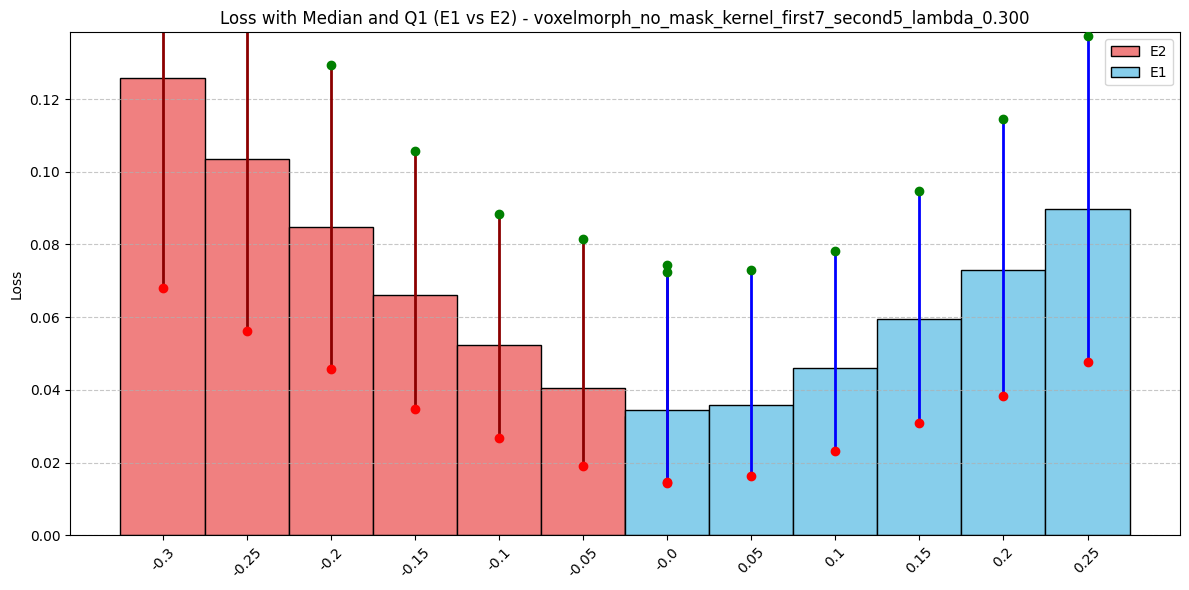

2025-06-27 19:01:31,495 - INFO - ✅ Evaluation completed successfully
2025-06-27 19:01:31,497 - INFO -    Processed: 877 samples
2025-06-27 19:01:31,498 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 19:01:31,936 - INFO - Loading best model: best_model_val_loss_0.00540.weights.h5 (val_loss=0.005400)



Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=0.4)
Progress: 23/24


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 19:01:32,611 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 19:01:32,612 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:37<00:00,  2.91it/s, samples=877, skipped=0]


0.2344051621261315
Range -0.30: MSE = 0.234405, Active Pixels = 2376
0.1809961018884861
Range -0.25: MSE = 0.180996, Active Pixels = 7056
0.13538003178572217
Range -0.20: MSE = 0.135380, Active Pixels = 14466
0.09443688016799939
Range -0.15: MSE = 0.094437, Active Pixels = 20827
0.0657985382127877
Range -0.10: MSE = 0.065799, Active Pixels = 29817
0.04030577880619368
Range -0.05: MSE = 0.040306, Active Pixels = 64287
0.03345364612376524
Range -0.00: MSE = 0.033454, Active Pixels = 171576
0.03581700700886154
Range 0.05: MSE = 0.035817, Active Pixels = 327756
0.04840428792408098
Range 0.10: MSE = 0.048404, Active Pixels = 428131
0.06490082515109
Range 0.15: MSE = 0.064901, Active Pixels = 464780
0.0814179511702218
Range 0.20: MSE = 0.081418, Active Pixels = 449477
0.10130771756152714
Range 0.25: MSE = 0.101308, Active Pixels = 384960
[0.11154054 0.15241171 0.12011025 0.1525796  0.12877996 0.19031572
 0.15618991 0.13306453 0.18605195 0.15620483 0.12853186 0.20186328
 0.21155127 0.17959519

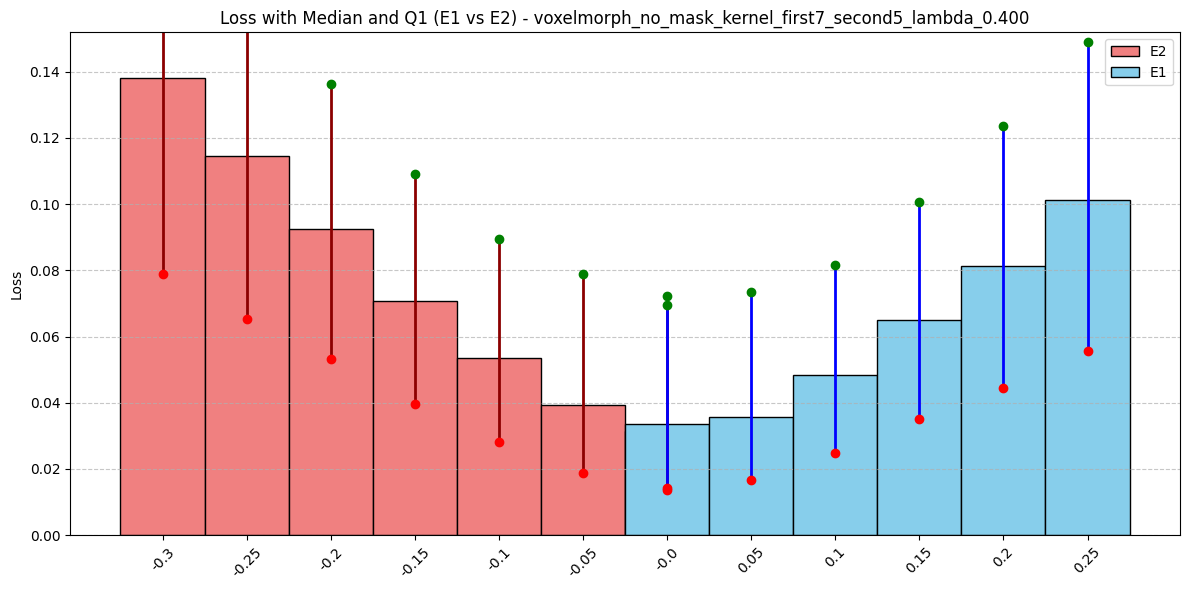

2025-06-27 19:02:25,886 - INFO - ✅ Evaluation completed successfully
2025-06-27 19:02:25,886 - INFO -    Processed: 877 samples
2025-06-27 19:02:25,887 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 19:02:26,295 - INFO - Loading best model: best_model_val_loss_0.00568.weights.h5 (val_loss=0.005680)



Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=0.5)
Progress: 24/25


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 19:02:27,012 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 19:02:27,013 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:32<00:00,  3.36it/s, samples=877, skipped=0]


0.23231005553054565
Range -0.30: MSE = 0.232310, Active Pixels = 2376
0.18242367181285113
Range -0.25: MSE = 0.182424, Active Pixels = 7056
0.13628049059733643
Range -0.20: MSE = 0.136280, Active Pixels = 14466
0.09489804789186268
Range -0.15: MSE = 0.094898, Active Pixels = 20827
0.06328722165302195
Range -0.10: MSE = 0.063287, Active Pixels = 29817
0.0391544924923736
Range -0.05: MSE = 0.039154, Active Pixels = 64287
0.03267214099296551
Range -0.00: MSE = 0.032672, Active Pixels = 171576
0.035539918271642226
Range 0.05: MSE = 0.035540, Active Pixels = 327756
0.04906547926652349
Range 0.10: MSE = 0.049065, Active Pixels = 428131
0.06757489000339428
Range 0.15: MSE = 0.067575, Active Pixels = 464780
0.08550155544058347
Range 0.20: MSE = 0.085502, Active Pixels = 449477
0.10596123520313366
Range 0.25: MSE = 0.105961, Active Pixels = 384960
[0.14074996 0.18590812 0.16285737 0.20457925 0.17358664 0.25551981
 0.21578017 0.1773694  0.24862694 0.20538577 0.16713974 0.2517606
 0.26315652 0.22

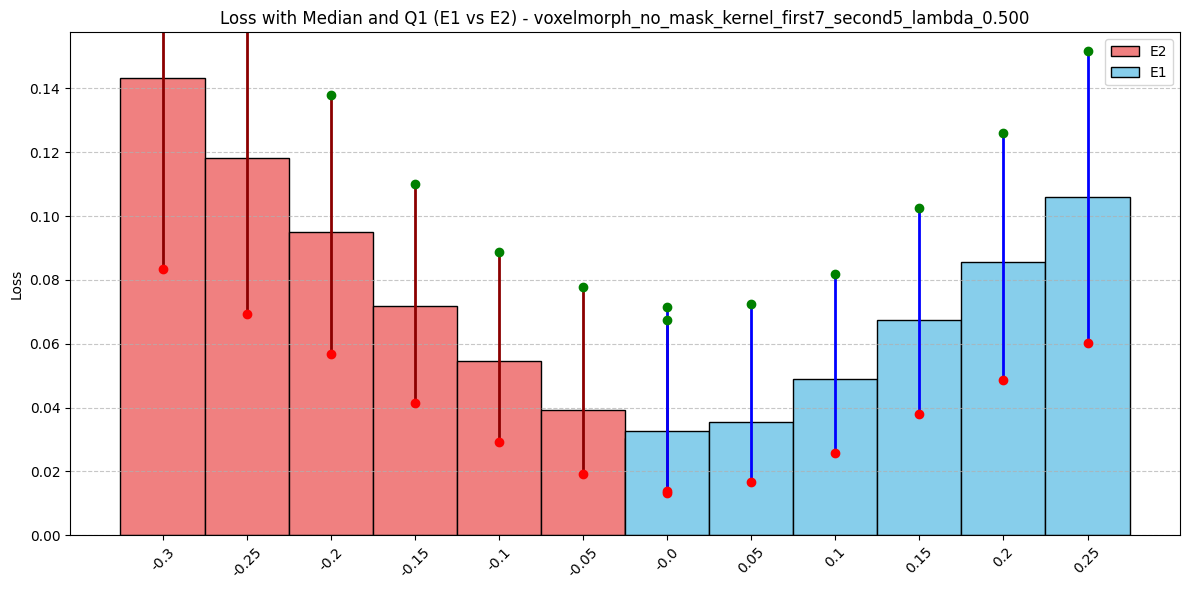

2025-06-27 19:03:16,788 - INFO - ✅ Evaluation completed successfully
2025-06-27 19:03:16,789 - INFO -    Processed: 877 samples
2025-06-27 19:03:16,790 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 19:03:17,203 - INFO - Loading best model: best_model_val_loss_0.00603.weights.h5 (val_loss=0.006030)



Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=0.6)
Progress: 25/26


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 19:03:17,851 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 19:03:17,852 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:32<00:00,  3.42it/s, samples=877, skipped=0]


0.24132207144051646
Range -0.30: MSE = 0.241322, Active Pixels = 2376
0.19018121112004968
Range -0.25: MSE = 0.190181, Active Pixels = 7056
0.14393427267500475
Range -0.20: MSE = 0.143934, Active Pixels = 14466
0.10169267211241317
Range -0.15: MSE = 0.101693, Active Pixels = 20827
0.06914883633287378
Range -0.10: MSE = 0.069149, Active Pixels = 29817
0.040970892875628884
Range -0.05: MSE = 0.040971, Active Pixels = 64287
0.030948935853540017
Range -0.00: MSE = 0.030949, Active Pixels = 171576
0.03514473712926923
Range 0.05: MSE = 0.035145, Active Pixels = 327756
0.051521115682679836
Range 0.10: MSE = 0.051521, Active Pixels = 428131
0.07242232507442867
Range 0.15: MSE = 0.072422, Active Pixels = 464780
0.09273610605048502
Range 0.20: MSE = 0.092736, Active Pixels = 449477
0.11520619070576893
Range 0.25: MSE = 0.115206, Active Pixels = 384960
[0.10238695 0.1339029  0.09600494 0.122774   0.09639604 0.16302734
 0.12051812 0.09652288 0.1522691  0.1160595  0.09974676 0.19720541
 0.18720777 

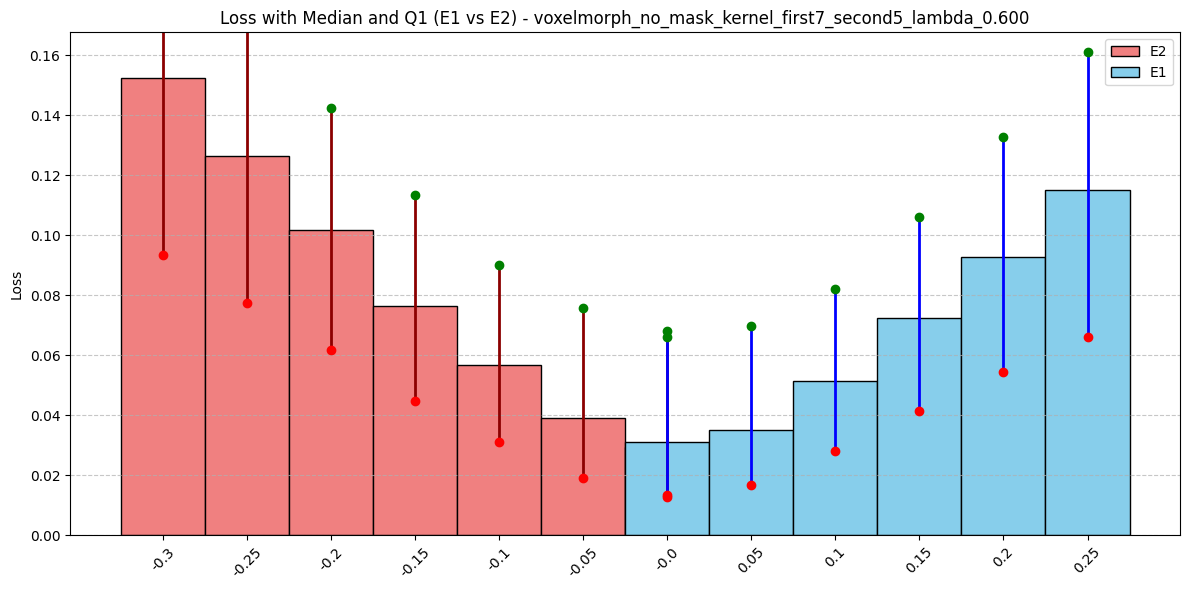

2025-06-27 19:04:07,355 - INFO - ✅ Evaluation completed successfully
2025-06-27 19:04:07,356 - INFO -    Processed: 877 samples
2025-06-27 19:04:07,356 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 19:04:07,824 - ERROR - No valid model files found in ./data\Models\voxelmorph_no_mask_kernel_first7_second5_lambda_0.700\weights
2025-06-27 19:04:07,825 - ERROR - Failed to load model for voxelmorph_no_mask (kernel=first7_second5, λ=0.7)



Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=0.7)
Progress: 26/27

Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=0.8)
Progress: 27/28


2025-06-27 19:04:08,148 - INFO - Loading best model: best_model_val_loss_0.00647.weights.h5 (val_loss=0.006470)
c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 19:04:08,791 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 19:04:08,792 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:32<00:00,  3.36it/s, samples=877, skipped=0]


0.25752795682247265
Range -0.30: MSE = 0.257528, Active Pixels = 2376
0.20658253615002253
Range -0.25: MSE = 0.206583, Active Pixels = 7056
0.15488158059243795
Range -0.20: MSE = 0.154882, Active Pixels = 14466
0.10861789657099788
Range -0.15: MSE = 0.108618, Active Pixels = 20827
0.07117179698587184
Range -0.10: MSE = 0.071172, Active Pixels = 29817
0.03988995486416323
Range -0.05: MSE = 0.039890, Active Pixels = 64287
0.02914942924759008
Range -0.00: MSE = 0.029149, Active Pixels = 171576
0.03636926305935144
Range 0.05: MSE = 0.036369, Active Pixels = 327756
0.05507115869128466
Range 0.10: MSE = 0.055071, Active Pixels = 428131
0.0781242006769305
Range 0.15: MSE = 0.078124, Active Pixels = 464780
0.10126972571801668
Range 0.20: MSE = 0.101270, Active Pixels = 449477
0.12659800269915894
Range 0.25: MSE = 0.126598, Active Pixels = 384960
[0.15146761 0.17395061 0.14728247 0.1654535  0.1510624  0.19188075
 0.16850222 0.15456564 0.18590366 0.16679298 0.15105194 0.18849299
 0.19962828 0.17

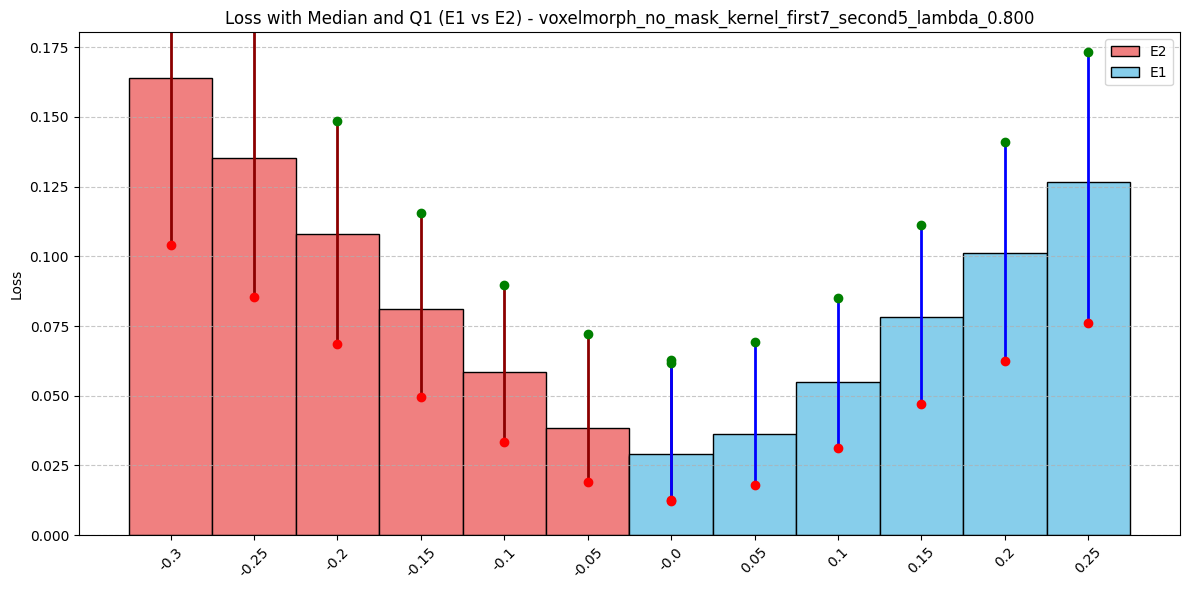

2025-06-27 19:04:59,874 - INFO - ✅ Evaluation completed successfully
2025-06-27 19:04:59,875 - INFO -    Processed: 877 samples
2025-06-27 19:04:59,876 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 19:05:00,387 - INFO - Loading best model: best_model_val_loss_0.00658.weights.h5 (val_loss=0.006580)



Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=0.9)
Progress: 28/29


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 19:05:01,084 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 19:05:01,085 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:30<00:00,  3.58it/s, samples=877, skipped=0]


0.26289722653559744
Range -0.30: MSE = 0.262897, Active Pixels = 2376
0.21074214644912673
Range -0.25: MSE = 0.210742, Active Pixels = 7056
0.1585006768224384
Range -0.20: MSE = 0.158501, Active Pixels = 14466
0.11186691981956609
Range -0.15: MSE = 0.111867, Active Pixels = 20827
0.07401846679832949
Range -0.10: MSE = 0.074018, Active Pixels = 29817
0.04033438644183092
Range -0.05: MSE = 0.040334, Active Pixels = 64287
0.029450199508182992
Range -0.00: MSE = 0.029450, Active Pixels = 171576
0.03558578025126271
Range 0.05: MSE = 0.035586, Active Pixels = 327756
0.05508173667452007
Range 0.10: MSE = 0.055082, Active Pixels = 428131
0.07932412239732453
Range 0.15: MSE = 0.079324, Active Pixels = 464780
0.10333325681922617
Range 0.20: MSE = 0.103333, Active Pixels = 449477
0.12989734656973362
Range 0.25: MSE = 0.129897, Active Pixels = 384960
[0.1668002  0.18074827 0.15460198 0.16757477 0.15250473 0.18804258
 0.16745516 0.15277214 0.18263436 0.16439842 0.15054966 0.17732488
 0.19632488 0.1

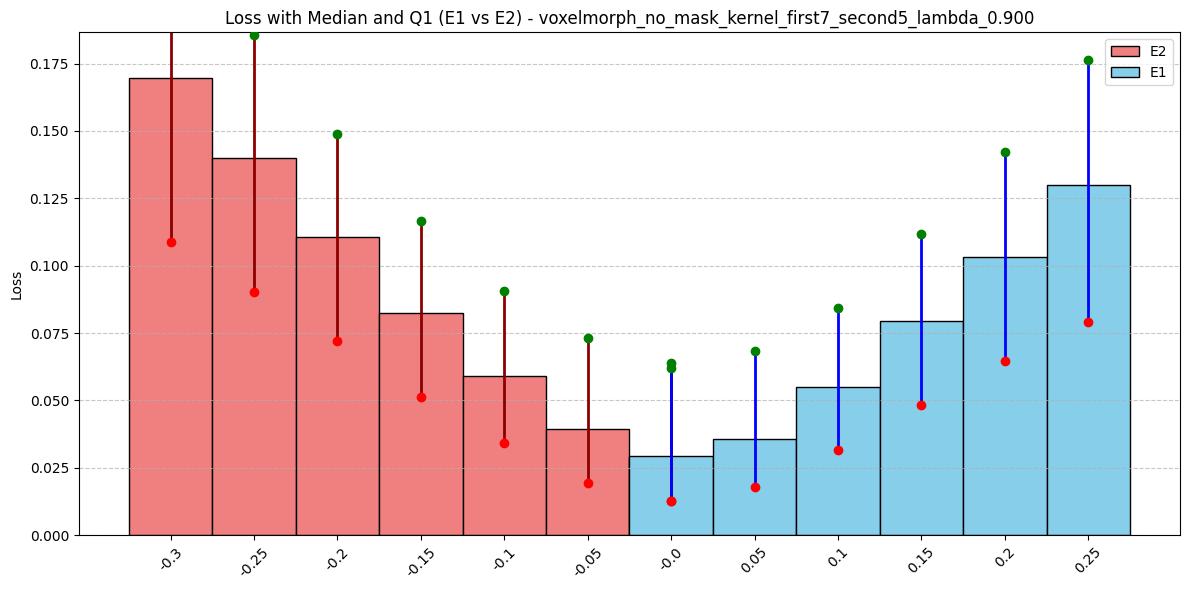

2025-06-27 19:05:50,186 - INFO - ✅ Evaluation completed successfully
2025-06-27 19:05:50,187 - INFO -    Processed: 877 samples
2025-06-27 19:05:50,188 - INFO -    Batches: 110 processed, 0 skipped
2025-06-27 19:05:50,582 - INFO - Loading best model: best_model_val_loss_0.00685.weights.h5 (val_loss=0.006850)



Evaluating voxelmorph_no_mask (kernel=first7_second5, λ=1.0)
Progress: 29/30


c:\Users\AliBadran\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 50 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-06-27 19:05:51,185 - INFO - ✅ Successfully loaded model (attempt 1)
2025-06-27 19:05:51,186 - INFO - Running evaluation: 110 steps, 877 total pairs
Evaluating model: 100%|██████████| 110/110 [00:31<00:00,  3.51it/s, samples=877, skipped=0]


0.26754986451373275
Range -0.30: MSE = 0.267550, Active Pixels = 2376
0.21708922032670078
Range -0.25: MSE = 0.217089, Active Pixels = 7056
0.16571196184766945
Range -0.20: MSE = 0.165712, Active Pixels = 14466
0.11839901703471434
Range -0.15: MSE = 0.118399, Active Pixels = 20827
0.07788227424946412
Range -0.10: MSE = 0.077882, Active Pixels = 29817
0.04176136669398905
Range -0.05: MSE = 0.041761, Active Pixels = 64287
0.028324491290640356
Range -0.00: MSE = 0.028324, Active Pixels = 171576
0.03545020561847456
Range 0.05: MSE = 0.035450, Active Pixels = 327756
0.05658976322530618
Range 0.10: MSE = 0.056590, Active Pixels = 428131
0.08252629388804707
Range 0.15: MSE = 0.082526, Active Pixels = 464780
0.1077559074226444
Range 0.20: MSE = 0.107756, Active Pixels = 449477
0.13603842490112758
Range 0.25: MSE = 0.136038, Active Pixels = 384960
[0.15793797 0.17899489 0.14435492 0.16228456 0.14581509 0.18369153
 0.1630867  0.1506414  0.18186294 0.16692222 0.1511971  0.17941638
 0.20095053 0.1

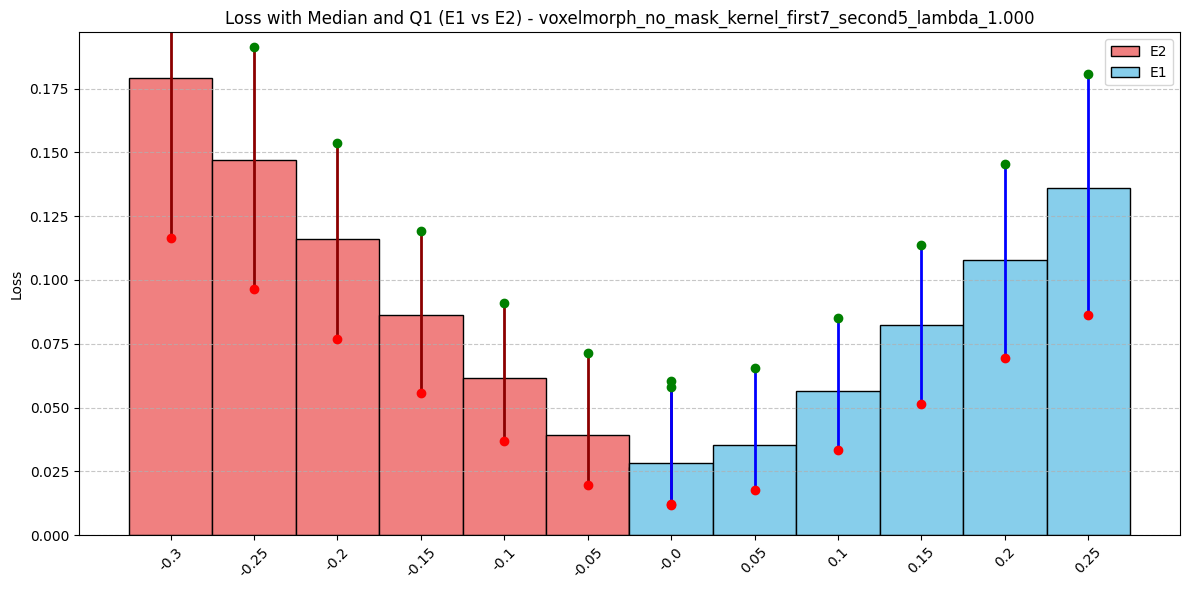

2025-06-27 19:06:41,853 - INFO - ✅ Evaluation completed successfully
2025-06-27 19:06:41,854 - INFO -    Processed: 877 samples
2025-06-27 19:06:41,854 - INFO -    Batches: 110 processed, 0 skipped



EVALUATION SUMMARY
Total models: 30
Successful: 26
Failed: 4
Success rate: 86.7%
Total time: 21.5 minutes
Average time per model: 42.9 seconds


In [8]:
# Test all models using the class
evaluate_simulated_models_improved(
    models_config=MODEL_CONFIG,
    lambdas=LAMBDAS,
    kernel_keys=KERNEL_KEYS,
    test_simulated_data=DATA_PATHS['test_simulated_data'],
    mask_simulated_data=DATA_PATHS['mask_simulated_data'],  
    displacement_simulated_data=DATA_PATHS['displacement_simulated_data']
)